In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pulp
import copy
from typing import Dict, List, Tuple, Optional, Any, Union
from dataclasses import dataclass, field
import warnings
import networkx as nx
from collections import defaultdict
import time
import math
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [55]:
# =============================================================================
# RANDOM CONNECTED GRAPH GENERATOR
# =============================================================================

def generate_random_connected_adjacency(num_servers: int, 
                                       edge_probability: float = 0.3,
                                       min_degree: int = 1,
                                       seed: Optional[int] = None) -> Dict[int, List[int]]:
    """
    Generate a random connected graph adjacency list.
    
    Uses Erdős-Rényi model with connectivity guarantee via MST.
    
    Parameters
    ----------
    num_servers : int
        Number of servers (nodes) in the graph
    edge_probability : float, optional
        Probability of edge creation between any two nodes (default: 0.3)
        Higher values create denser graphs
    min_degree : int, optional
        Minimum degree for each node (default: 1)
        Ensures no isolated nodes
    seed : int, optional
        Random seed for reproducibility
    
    Returns
    -------
    Dict[int, List[int]]
        Adjacency list where keys are server IDs and values are lists of neighbors
    
    Examples
    --------
    >>> adj = generate_random_connected_adjacency(5, edge_probability=0.4)
    >>> print(adj)
    {0: [1, 3], 1: [0, 2, 4], 2: [1, 3], 3: [0, 2, 4], 4: [1, 3]}
    
    >>> # For a sparser graph
    >>> adj = generate_random_connected_adjacency(10, edge_probability=0.2, seed=42)
    """
    if num_servers < 2:
        raise ValueError("Number of servers must be at least 2")
    
    if not 0 <= edge_probability <= 1:
        raise ValueError("edge_probability must be between 0 and 1")
    
    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # Step 1: Create a Minimum Spanning Tree to ensure connectivity
    # Generate random edge weights for all possible edges
    edges = []
    for i in range(num_servers):
        for j in range(i + 1, num_servers):
            weight = np.random.random()
            edges.append((weight, i, j))
    
    # Sort edges by weight (Kruskal's algorithm)
    edges.sort()
    
    # Use Union-Find to build MST
    parent = list(range(num_servers))
    
    def find(x):
        if parent[x] != x:
            parent[x] = find(parent[x])
        return parent[x]
    
    def union(x, y):
        px, py = find(x), find(y)
        if px != py:
            parent[px] = py
            return True
        return False
    
    # Build adjacency from MST edges
    adjacency = {i: [] for i in range(num_servers)}
    mst_edges = []
    
    for weight, u, v in edges:
        if union(u, v):
            adjacency[u].append(v)
            adjacency[v].append(u)
            mst_edges.append((u, v))
            if len(mst_edges) == num_servers - 1:
                break
    
    # Step 2: Add random edges based on edge_probability
    for i in range(num_servers):
        for j in range(i + 1, num_servers):
            # Skip if edge already exists (from MST)
            if j in adjacency[i]:
                continue
            
            # Add edge with given probability
            if np.random.random() < edge_probability:
                adjacency[i].append(j)
                adjacency[j].append(i)
    
    # Step 3: Ensure minimum degree requirement
    for node in range(num_servers):
        current_degree = len(adjacency[node])
        if current_degree < min_degree:
            # Find potential neighbors not already connected
            potential_neighbors = [n for n in range(num_servers) 
                                 if n != node and n not in adjacency[node]]
            
            # Randomly select additional neighbors
            num_to_add = min(min_degree - current_degree, len(potential_neighbors))
            new_neighbors = np.random.choice(potential_neighbors, num_to_add, replace=False)
            
            for neighbor in new_neighbors:
                adjacency[node].append(neighbor)
                adjacency[neighbor].append(node)
    
    # Step 4: Sort neighbor lists for consistency
    for node in adjacency:
        adjacency[node] = sorted(adjacency[node])
    
    return adjacency


def visualize_adjacency(adjacency: Dict[int, List[int]], 
                       title: str = "Network Topology",
                       figsize: Tuple[int, int] = (10, 8),
                       node_size: int = 800,
                       save_path: Optional[str] = None):
    G = nx.Graph()
    for node, neighbors in adjacency.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Use spring layout for nice positioning
    pos = nx.spring_layout(G, seed=42, k=1, iterations=50)
    
    # Draw graph
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=node_size, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=2)
    
    # Add statistics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_degree = 2 * num_edges / num_nodes if num_nodes > 0 else 0
    diameter = nx.diameter(G) if nx.is_connected(G) else float('inf')
    
    info_text = f"Nodes: {num_nodes} | Edges: {num_edges} | Avg Degree: {avg_degree:.2f} | Diameter: {diameter}"
    plt.text(0.5, 0.02, info_text, ha='center', transform=plt.gcf().transFigure,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved visualization to {save_path}")
    
    plt.show()


# Example usage
print("✓ Random connected graph generator defined")
print("\nUsage:")
print("  # Generate random connected graph")
print("  adj = generate_random_connected_adjacency(num_servers=10, edge_probability=0.3)")
print("  ")
print("  # Visualize it")
print("  visualize_adjacency(adj, title='My Network')")
print("  ")
print("  # Use in config")
print("  config.override(adjacency=adj)")

✓ Random connected graph generator defined

Usage:
  # Generate random connected graph
  adj = generate_random_connected_adjacency(num_servers=10, edge_probability=0.3)
  
  # Visualize it
  visualize_adjacency(adj, title='My Network')
  
  # Use in config
  config.override(adjacency=adj)


In [56]:
# =============================================================================
# CONFIGURATION CLASS - Complete Hyperparameter Control
# =============================================================================

@dataclass
class uEDDEConfig:
    """
    Complete configuration for Online uEDDE with Two-Stage Robust Optimization
    All parameters can be manually overridden
    """
    
    # ========== TIME HORIZON ==========
    T: int = 5  # Number of time slots
    
    # ========== DATASETS ==========
    num_datasets: int = 3
    dataset_sizes: Dict[int, float] = field(default_factory=lambda: {})  # s_i
    hop_budgets: Dict[int, int] = field(default_factory=lambda: {})  # H_i (dataset-specific)
    
    # ========== SERVERS ==========
    num_servers: int = 5
    server_capacities: Dict[int, float] = field(default_factory=lambda: {})  # C_j
    server_bandwidth: Dict[int, float] = field(default_factory=lambda: {})  # BW_j (optional ingress)
    
    # ========== NETWORK TOPOLOGY ==========
    adjacency: Dict[int, List[int]] = field(default_factory=lambda: {})  # Adjacency list
    hop_distances: Dict[Tuple[int, int], int] = field(default_factory=lambda: {})  # Precomputed h_{j,p}
    
    # ========== ROBUSTNESS PARAMETERS ==========
    use_robust: bool = True  # Enable two-stage robust optimization
    K_failures: int = 1  # Maximum failures per slot (K_t)
    Gamma_budget: float = 2.0  # Bertsimas-Sim uncertainty budget
    use_k_survivable_coverage: bool = False  # Use m_{ip,t} = min(K_t+1, |N_p(H_i)|) in nominal coverage
    
    # ========== OPTIMIZATION WEIGHTS ==========
    rho: float = 0.5  # Trade-off: 0=nominal only, 1=worst-case only
    lambda_add: float = 1.0  # Weight for add (migration) cost
    eta_stability: float = 0.0  # Optional stability penalty for state flips
    
    # ========== OPTIONAL CONSTRAINTS ==========
    use_ingress_constraint: bool = False  # Enforce bandwidth limits
    use_xor_constraint: bool = True  # Prevent simultaneous add/remove
    enforce_recourse_from_prev: bool = False  # q_{ij,t} <= A_{ij,t-1} (paper-faithful)
    
    # ========== SOLVER SELECTION ==========
    solver_type: str = "milp"  # Options: "milp", "greedy_adr", "custom"
    solver_time_limit: int = 300  # Time limit in seconds for MILP
    solver_gap: float = 0.01  # MIP gap tolerance
    
    # ========== CCG (Column-and-Constraint Generation) ==========
    use_ccg: bool = True  # Use iterative CCG for exact solution
    ccg_max_iterations: int = 20  # Max CCG iterations per time slot
    ccg_tolerance: float = 1e-4  # Convergence tolerance
    
    # ========== GREEDY HEURISTIC PARAMETERS ==========
    greedy_enable_pruning: bool = True  # Reverse-prune redundant replicas
    greedy_scoring_method: str = "robust"  # Options: "nominal", "robust", "hybrid"
    
    # ========== DATASET LOADING ==========
    dataset_source: str = "synthetic"  # Options: "synthetic", "netflix", "spotify", "custom"
    custom_dataset_path: Optional[str] = None  # Path to custom CSV
    
    # ========== VISUALIZATION ==========
    plot_per_slot: bool = True  # Show detailed per-slot results
    plot_summary: bool = True  # Show aggregate plots
    save_plots: bool = False  # Save plots to disk
    plot_output_dir: str = "./results"  # Output directory
    
    def __post_init__(self):
        """Initialize default values for dictionaries"""
        if not self.dataset_sizes:
            self.dataset_sizes = {i: 10.0 + i*5 for i in range(self.num_datasets)}
        if not self.hop_budgets:
            self.hop_budgets = {i: 2 + i % 2 for i in range(self.num_datasets)}
        if not self.server_capacities:
            self.server_capacities = {j: 50.0 for j in range(self.num_servers)}
        if not self.server_bandwidth:
            self.server_bandwidth = {j: 30.0 for j in range(self.num_servers)}
        if not self.adjacency:
            self.adjacency = generate_random_connected_adjacency(num_servers=self.num_servers, edge_probability=0.5)
    
    def get_add_cost(self, i: int, j: int, t: int) -> float:
        """Cost of adding dataset i to server j at time t"""
        return self.dataset_sizes[i] * 0.1  # Simple linear model
    
    def override(self, **kwargs):
        """Override any configuration parameter"""
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Unknown parameter: {key}")
        
        # Regenerate dependent dictionaries if num_datasets or num_servers changed
        if 'num_datasets' in kwargs:
            if not kwargs.get('dataset_sizes'):  # Only if not manually provided
                self.dataset_sizes = {i: 10.0 + i*5 for i in range(self.num_datasets)}
            if not kwargs.get('hop_budgets'):
                self.hop_budgets = {i: 2 + i % 2 for i in range(self.num_datasets)}
        
        if 'num_servers' in kwargs:
            if not kwargs.get('server_capacities'):
                self.server_capacities = {j: 50.0 for j in range(self.num_servers)}
            if not kwargs.get('server_bandwidth'):
                self.server_bandwidth = {j: 30.0 for j in range(self.num_servers)}
            if not kwargs.get('adjacency'):
                self.adjacency = generate_random_connected_adjacency(num_servers=self.num_servers, edge_probability=0.5)

    
    def to_dict(self) -> Dict[str, Any]:
        """Export configuration as dictionary"""
        return {
            'T': self.T,
            'num_datasets': self.num_datasets,
            'num_servers': self.num_servers,
            'rho': self.rho,
            'K_failures': self.K_failures,
            'Gamma_budget': self.Gamma_budget,
            'lambda_add': self.lambda_add,
            'solver_type': self.solver_type,
            'use_robust': self.use_robust
        }
    
    def print_summary(self):
        """Print configuration summary"""
        print("="*80)
        print("CONFIGURATION SUMMARY")
        print("="*80)
        print(f"Time Horizon: {self.T} slots")
        print(f"Datasets: {self.num_datasets}, Servers: {self.num_servers}")
        print(f"Hop Budgets: {self.hop_budgets}")
        print(f"K-Failure Budget: {self.K_failures}")
        print(f"BS Uncertainty Budget (Γ): {self.Gamma_budget}")
        print(f"Blend Parameter (ρ): {self.rho}")
        print(f"Solver: {self.solver_type}")
        print(f"Robust Optimization: {'Enabled' if self.use_robust else 'Disabled'}")
        visualize_adjacency(self.adjacency, title='My Network')
        print("="*80)

# Create default configuration
config = uEDDEConfig()
print("✓ Configuration class defined")
print("\nUsage:")
print("  config = uEDDEConfig()")
print("  config.override(T=10, rho=0.7, solver_type='greedy_adr')")

✓ Configuration class defined

Usage:
  config = uEDDEConfig()
  config.override(T=10, rho=0.7, solver_type='greedy_adr')


In [57]:
# =============================================================================
# DATA GENERATOR - Modular Dataset Support
# =============================================================================
class DataGenerator:
    """
    Generate or load data for uEDDE problem
    Supports: synthetic, Netflix, Spotify, or custom datasets
    """
    
    def __init__(self, config: uEDDEConfig, seed: int = 42):
        self.config = config
        self.rng = np.random.default_rng(seed)
        
        # Compute hop distances from adjacency
        self._compute_hop_distances()
        
        # Data structures (to be populated)
        self.initial_state: Dict[Tuple[int, int], int] = {}  # A_{ij,0}
        self.counts: Dict[Tuple[int, int, int], int] = {}  # N^i_{p,t}
        self.weights_nominal: Dict[Tuple[int, int, int], float] = {}  # bar_Upsilon_{ip,t}
        self.weights_error: Dict[Tuple[int, int, int], float] = {}  # hat_Upsilon_{ip,t}
        self.active_datasets: Dict[Tuple[int, int], int] = {}  # alpha_{i,t}
        self.attachment_points: Dict[int, List[int]] = {}  # P_t
        
    def _compute_hop_distances(self):
        """Compute all-pairs shortest paths (hop distances)"""
        if self.config.hop_distances:
            print("✓ Using precomputed hop distances")
            return
        
        G = nx.Graph()
        for node, neighbors in self.config.adjacency.items():
            for neighbor in neighbors:
                G.add_edge(node, neighbor)
        
        self.config.hop_distances = {}
        for source in range(self.config.num_servers):
            try:
                lengths = nx.single_source_shortest_path_length(G, source)
            except:
                lengths = {source: 0}
            
            for target in range(self.config.num_servers):
                self.config.hop_distances[(source, target)] = lengths.get(target, float('inf'))
        
        print(f"✓ Computed hop distances for {self.config.num_servers} servers")
    
    def get_neighborhood(self, p: int, hop_budget: int) -> List[int]:
        """Get neighborhood N_p(H_i) = {j: h_{j,p} <= H_i}"""
        neighborhood = []
        for j in range(self.config.num_servers):
            if self.config.hop_distances.get((j, p), float('inf')) <= hop_budget:
                neighborhood.append(j)
        return neighborhood
    
    # ========== INITIAL STATE ==========
    
    def generate_initial_state(self, manual_state: Optional[Dict] = None, 
                               sparsity: float = 0.3):
        """Generate or load initial placement A_{ij,0}"""
        if manual_state is not None:
            self.initial_state = manual_state
            print("✓ Using manual initial state")
        else:
            self.initial_state = {}
            for i in range(self.config.num_datasets):
                for j in range(self.config.num_servers):
                    self.initial_state[(i, j)] = 1 if self.rng.random() < sparsity else 0
            print(f"✓ Generated random initial state (sparsity={sparsity})")
        
        # Validate capacity
        for j in range(self.config.num_servers):
            total = sum(self.config.dataset_sizes[i] * self.initial_state[(i, j)] 
                       for i in range(self.config.num_datasets))
            if total > self.config.server_capacities[j]:
                print(f"⚠ Warning: Server {j} capacity violated ({total:.1f} > {self.config.server_capacities[j]})")
        
        return self.initial_state
    
    # ========== REQUEST COUNTS ==========
    
    def generate_counts(self, manual_counts: Optional[Dict] = None):
        """Generate request counts N^i_{p,t}"""
        if manual_counts is not None:
            self.counts = manual_counts
            self._extract_attachment_points()
            print("✓ Using manual request counts")
        else:
            self._generate_synthetic_counts()
            print(f"✓ Generated synthetic request counts for {self.config.T} time slots")
        return self.counts
    
    def _generate_synthetic_counts(self):
        """Generate synthetic Poisson-like counts"""
        self.counts = {}
        self.attachment_points = {}
        
        for t in range(1, self.config.T + 1):
            # Random active APs
            num_active = self.rng.integers(2, self.config.num_servers + 1)
            active_aps = self.rng.choice(self.config.num_servers, num_active, replace=False)
            self.attachment_points[t] = list(active_aps)
            
            for p in active_aps:
                for i in range(self.config.num_datasets):
                    # Poisson arrivals with time-varying rate
                    base_rate = 5 + 2 * i
                    time_factor = 1 + 0.3 * np.sin(2 * np.pi * t / self.config.T)
                    count = self.rng.poisson(base_rate * time_factor)
                    self.counts[(i, p, t)] = count
    
    def _extract_attachment_points(self):
        """Extract P_t from manual counts"""
        self.attachment_points = {}
        for (i, p, t) in self.counts.keys():
            if t not in self.attachment_points:
                self.attachment_points[t] = []
            if p not in self.attachment_points[t]:
                self.attachment_points[t].append(p)
        # print("Attachment points for every time:")
        # print(self.attachment_points[1435])
    
    def load_dataset(self, file_path: str):
        """Load dataset from CSV with columns: timestamp, server, dataset"""
        print(f"Loading dataset from {file_path}...")
        try:
            df = pd.read_csv(file_path)
            
            # Validate required columns
            required_cols = ['timestamp', 'server', 'dataset']
            if not all(col in df.columns for col in required_cols):
                raise ValueError(f"CSV must contain columns: {required_cols}, found: {list(df.columns)}")
            
            # Sort by timestamp
            df = df.sort_values('timestamp')
            
            # Map timestamps to time slots (1 to T)
            # Ensure timestamps are mapped uniformly across the range
            unique_timestamps = sorted(df['timestamp'].unique())
            if len(unique_timestamps) <= self.config.T:
                # Few unique timestamps: map directly
                timestamp_to_slot = {ts: min(idx + 1, self.config.T) 
                                    for idx, ts in enumerate(unique_timestamps)}
            else:
                # Many timestamps: bin them into T slots
                df['time_slot'] = pd.cut(df['timestamp'], bins=self.config.T, labels=False) + 1
            
            # If we used direct mapping, apply it
            if 'time_slot' not in df.columns:
                df['time_slot'] = df['timestamp'].map(timestamp_to_slot)
            
            # Aggregate counts: group by (dataset, server, time_slot) and count occurrences
            self.counts = {}
            grouped = df.groupby(['dataset', 'server', 'time_slot']).size()
            # print(grouped.items())
            for (dataset_id, server_id, time_slot), count in grouped.items():
                # Validate indices
                if dataset_id >= self.config.num_datasets:
                    continue  # Skip datasets beyond configured range
                if server_id >= self.config.num_servers:
                    continue  # Skip servers beyond configured range
                if time_slot < 1 or time_slot > self.config.T:
                    continue  # Skip invalid time slots
                
                # Store count: (dataset_id, server_id, time_slot) -> count
                key = (int(dataset_id), int(server_id), int(time_slot))
                self.counts[key] = int(count)
            # print(self.counts)
            
            # Extract attachment points (servers that have requests in each time slot)
            self._extract_attachment_points()
            
            print(f"✓ Loaded {len(self.counts)} request records from dataset")
            print(f"  Time slots: {sorted(set(t for _, _, t in self.counts.keys()))}")
            print(f"  Datasets: {sorted(set(i for i, _, _ in self.counts.keys()))}")
            print(f"  Servers (APs): {sorted(set(p for _, p, _ in self.counts.keys()))}")
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            print("  Falling back to synthetic data")
            self._generate_synthetic_counts()
    
    # ========== ACTIVE DATASETS ==========
    
    def generate_active_datasets(self, manual_active: Optional[Dict] = None,
                                 activity_prob: float = 0.8):
        """Generate active dataset indicators alpha_{i,t}"""
        if manual_active is not None:
            self.active_datasets = manual_active
            print("✓ Using manual active datasets")
        else:
            self.active_datasets = {}
            for t in range(1, self.config.T + 1):
                for i in range(self.config.num_datasets):
                    self.active_datasets[(i, t)] = 1 if self.rng.random() < activity_prob else 0
            
            # Enforce C0-count: inactive datasets have zero counts
            for (i, p, t), count in list(self.counts.items()):
                if self.active_datasets.get((i, t), 0) == 0:
                    self.counts[(i, p, t)] = 0
            
            print(f"✓ Generated active dataset indicators (activity={activity_prob})")
        
        return self.active_datasets
    
    # ========== WEIGHTS (UNCERTAINTY) ==========
    
    def generate_weights(self, manual_nominal: Optional[Dict] = None,
                        manual_error: Optional[Dict] = None,
                        error_pct_range: Tuple[float, float] = (0.1, 0.3)):
        """Generate nominal and error weights for BS uncertainty"""
        if manual_nominal is not None and manual_error is not None:
            self.weights_nominal = manual_nominal
            self.weights_error = manual_error
            print("✓ Using manual weights")
        else:
            self.weights_nominal = {}
            self.weights_error = {}
            
            for t in range(1, self.config.T + 1):
                for p in self.attachment_points.get(t, []):
                    for i in range(self.config.num_datasets):
                        # Nominal weight (uniform around 1.0)
                        self.weights_nominal[(i, p, t)] = 0.8 + 0.4 * self.rng.random()
                        
                        # Error bound (percentage of nominal)
                        error_pct = error_pct_range[0] + (error_pct_range[1] - error_pct_range[0]) * self.rng.random()
                        self.weights_error[(i, p, t)] = self.weights_nominal[(i, p, t)] * error_pct
            
            print(f"✓ Generated weights with error range {error_pct_range}")
        
        return self.weights_nominal, self.weights_error
    
    # ========== MASTER GENERATION ==========
    
    def generate_all(self, dataset_source: Optional[str] = None,activity = 0.8):
        """Generate all data based on configuration"""
        source = dataset_source or self.config.dataset_source
        
        self.generate_initial_state()
        
        if source == "data" and self.config.custom_dataset_path:
            self.load_dataset(self.config.custom_dataset_path)
        elif source == "synthetic":
            self.generate_counts()
        else:
            print(f"⚠ Unknown dataset source: {source}, using synthetic")
            self.generate_counts()
        self.generate_active_datasets(activity_prob=activity)
        self.generate_weights()
        
        return self
    
    def print_summary(self):
        """Print data summary"""
        print("\n" + "="*80)
        print("DATA SUMMARY")
        print("="*80)
        print(f"Initial placements: {sum(self.initial_state.values())} replicas")
        print(f"Total requests: {sum(self.counts.values())}")
        print(f"Time slots with requests: {self.attachment_points}")
        print(f"Unique attachment points: {len(set(p for t in self.attachment_points.values() for p in t))}")
        print(f"Active datasets (avg): {np.mean([sum(self.active_datasets.get((i,t),0) for i in range(self.config.num_datasets)) for t in range(1, self.config.T+1)]):.1f}")
        print("="*80)

print("✓ DataGenerator class defined")

✓ DataGenerator class defined


In [58]:
# =============================================================================
# SOLVER BASE CLASS - Abstract Interface
# =============================================================================

from abc import ABC, abstractmethod

@dataclass
class SlotSolution:
    """Solution for a single time slot"""
    time_slot: int
    adds: Dict[Tuple[int, int], int] = field(default_factory=dict)  # a_{ij,t}
    removes: Dict[Tuple[int, int], int] = field(default_factory=dict)  # r_{ij,t}
    states: Dict[Tuple[int, int], int] = field(default_factory=dict)  # x_{ij,t}
    
    # Worst-case scenario info
    failures: Dict[int, int] = field(default_factory=dict)  # f_{j,t}
    survivors: Dict[Tuple[int, int], float] = field(default_factory=dict)  # y_{ij,t}
    recourse_removes: Dict[Tuple[int, int], int] = field(default_factory=dict)  # q_{ij,t}
    post_recourse: Dict[Tuple[int, int], int] = field(default_factory=dict)  # z_{ij,t}
    
    # Ring variables
    ring_nominal: Dict[Tuple[int, int, int], int] = field(default_factory=dict)  # w^nom_{ipd}
    ring_wc: Dict[Tuple[int, int, int], int] = field(default_factory=dict)  # w^wc_{ipd}
    
    # Benefits
    benefit_nominal_per_ip: Dict[Tuple[int, int], float] = field(default_factory=dict)  # B^nom_{ip,t}
    benefit_wc_per_ip: Dict[Tuple[int, int], float] = field(default_factory=dict)  # B^wc_{ip,t}
    
    # Objectives
    R_nominal: float = 0.0
    R_wc: float = 0.0
    B_nominal: float = 0.0
    B_wc: float = 0.0
    Op_cost: float = 0.0
    objective_value: float = 0.0
    
    # Metadata
    solve_time: float = 0.0
    status: str = "unknown"
    ccg_iterations: int = 0

@dataclass
class GlobalSolution:
    """Complete solution across all time slots"""
    config: uEDDEConfig
    slot_solutions: List[SlotSolution] = field(default_factory=list)
    total_objective: float = 0.0
    total_solve_time: float = 0.0
    
    def add_slot_solution(self, sol: SlotSolution):
        self.slot_solutions.append(sol)
        self.total_objective += sol.objective_value
        self.total_solve_time += sol.solve_time


class BaseSolver(ABC):
    """Abstract base class for all solvers"""
    
    def __init__(self, config: uEDDEConfig, data_gen: DataGenerator):
        self.config = config
        self.data = data_gen
        self.solution = GlobalSolution(config=config)
    
    @abstractmethod
    def solve_slot(self, t: int, A_prev: Dict[Tuple[int, int], int]) -> SlotSolution:
        """Solve for a single time slot given previous state"""
        pass
    
    def solve_all(self) -> GlobalSolution:
        """Solve across all time slots (online)"""
        print("\n" + "="*80)
        print(f"SOLVING ONLINE uEDDE [{self.__class__.__name__}]")
        print("="*80)
        
        A_prev = self.data.initial_state.copy()
        
        for t in range(1, self.config.T + 1):
            print(f"\n{'─'*80}")
            print(f"Time Slot {t}/{self.config.T}")
            print(f"{'─'*80}")
            
            slot_sol = self.solve_slot(t, A_prev)
            self.solution.add_slot_solution(slot_sol)
            
            # Update state for next slot
            A_prev = slot_sol.states.copy()
            
            print(f"✓ Slot {t} complete: Obj={slot_sol.objective_value:.4f}, "
                  f"Adds={len(slot_sol.adds)}, Removes={len(slot_sol.removes)}, "
                  f"Time={slot_sol.solve_time:.2f}s")
        
        print("\n" + "="*80)
        print(f"TOTAL OBJECTIVE: {self.solution.total_objective:.4f}")
        print(f"TOTAL TIME: {self.solution.total_solve_time:.2f}s")
        print("="*80)
        
        return self.solution
    
    def print_solution(self):
        """Print detailed solution report"""
        from datetime import datetime
        
        print("\n" + "="*80)
        print("DETAILED SOLUTION REPORT")
        print("="*80)
        print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Solver: {self.__class__.__name__}")
        print(f"Config: T={self.config.T}, I={self.config.num_datasets}, "
              f"J={self.config.num_servers}, K={self.config.K_failures}, "
              f"Γ={self.config.Gamma_budget}, ρ={self.config.rho}")
        print("="*80)
        
        for slot_sol in self.solution.slot_solutions:
            self._print_slot_solution(slot_sol)
    
    def _print_slot_solution(self, sol: SlotSolution):
        """Print solution for one slot"""
        t = sol.time_slot
        print(f"\n{'═'*80}")
        print(f"TIME SLOT t={t}")
        print(f"{'═'*80}")
        
        # Requests
        print(f"\n📊 Request Distribution:")
        for p in self.data.attachment_points.get(t, []):
            total_requests = sum(self.data.counts.get((i, p, t), 0) 
                                for i in range(self.config.num_datasets))
            if total_requests > 0:
                print(f"  AP {p}: {total_requests} requests")
                for i in range(self.config.num_datasets):
                    count = self.data.counts.get((i, p, t), 0)
                    if count > 0:
                        weight = self.data.weights_nominal.get((i, p, t), 1.0)
                        print(f"    Dataset {i}: {count} reqs (weight={weight:.3f})")
        
        # First-stage decisions
        print(f"\n📥 First-Stage Decisions:")
        if sol.adds:
            print(f"  Adds ({len(sol.adds)}):")
            for (i, j), val in sorted(sol.adds.items()):
                if val > 0:
                    cost = self.config.get_add_cost(i, j, t)
                    print(f"    Dataset {i} → Server {j} (cost={cost:.2f})")
        else:
            print(f"  Adds: none")
        
        if sol.removes:
            print(f"  Removes ({len(sol.removes)}):")
            for (i, j), val in sorted(sol.removes.items()):
                if val > 0:
                    print(f"    Dataset {i} ← Server {j}")
        else:
            print(f"  Removes: none")
        
        # Post-first-stage placement
        print(f"\n📍 Post-First-Stage Placement:")
        for i in range(self.config.num_datasets):
            servers = [j for (ii, j), val in sol.states.items() if ii == i and val > 0]
            if servers:
                print(f"  Dataset {i}: servers {sorted(servers)}")
            else:
                print(f"  Dataset {i}: not placed")
        
        # Worst-case scenario
        if self.config.use_robust and sol.failures:
            print(f"\n⚠️  Worst-Case Scenario:")
            failed = [j for j, val in sol.failures.items() if val > 0]
            print(f"  Failed servers: {failed if failed else 'none'}")
            
            if sol.recourse_removes:
                print(f"  Recourse removes:")
                for (i, j), val in sorted(sol.recourse_removes.items()):
                    if val > 0:
                        print(f"    Dataset {i} ← Server {j}")
        
        # Objective components
        print(f"\n🎯 Objective Components:")
        print(f"  R_nominal (dedup ratio): {sol.R_nominal:.4f}")
        print(f"  B_nominal (benefit): {sol.B_nominal:.4f}")
        if self.config.use_robust:
            print(f"  R_wc (worst-case dedup): {sol.R_wc:.4f}")
            print(f"  B_wc (worst-case benefit): {sol.B_wc:.4f}")
        print(f"  Op_cost (migration): {sol.Op_cost:.4f}")
        print(f"  ▶ Total Objective: {sol.objective_value:.4f}")
        
        print(f"\n⏱️  Solve time: {sol.solve_time:.2f}s, Status: {sol.status}")

print("✓ BaseSolver class defined")

✓ BaseSolver class defined


In [59]:
# =============================================================================
# MILP SOLVER - Two-Stage Robust Implementation with CCG (AP-alive gated)
# =============================================================================
class MILPSolver(BaseSolver):
    """
    MILP solver using PuLP with Column-and-Constraint Generation (CCG).
    Two-stage robust per LaTeX (Option B: rings d=0..H_i) with AP-alive gating:
      - If AP p fails in a scenario: its coverage/rings/benefit terms are dropped.

    Notes / Fixes vs previous version:
      • Adversary still knocks out nodes from J (servers). APs are assumed to be
        a subset of J (as the rest of the code gates with f[p] where p ∈ J).
      • All B-normalizations in scenario/recourse use ONLY *alive* APs in the
        denominator (N_sum_alive) to avoid washing out B and producing zeros.
      • η is now unbounded below (lowBound=None) to be a true epigraph variable.
      • More informative oracle logging.
    """

    def __init__(self, config: uEDDEConfig, data_gen: DataGenerator):
        super().__init__(config, data_gen)
        self.model = None
        self.vars = {}

    # -------------------------------------------------------------------------
    # Public API
    # -------------------------------------------------------------------------
    def solve_slot(self, t: int, A_prev: Dict[Tuple[int, int], int]) -> SlotSolution:
        start_time = time.time()
        if self.config.use_robust and self.config.use_ccg:
            sol = self._solve_slot_ccg(t, A_prev)
        else:
            sol = self._solve_slot_direct(t, A_prev)
        sol.solve_time = time.time() - start_time
        return sol

    # -------------------------------------------------------------------------
    # CCG Adversarial: pick failures only (coverage separator + recourse eval)
    # -------------------------------------------------------------------------
    def _solve_adversarial_subproblem(self, t: int, A_prev: Dict[Tuple[int, int], int],
                                      x_fixed: Dict[Tuple[int, int], int]) -> Dict:
        """
        Given x (first-stage placement), return the worst failure pattern f (<=K)
        and its robust value: adv_value = R_wc_nominal + (B_wc_nominal - BS_penalty).

        Steps:
          1) Greedy K-knockout over servers J (APs are a subset of J): minimize #covered (i,p) on ALIVE p.
          2) Solve recourse-only MAX (with x,f fixed) to get R_wc_nominal and B_wc_nominal (AP-gated).
          3) Apply BS penalty in closed form using only alive APs (N_sum over alive APs).
        """
        I = range(self.config.num_datasets)
        J = range(self.config.num_servers)
        P_t = self.data.attachment_points.get(t, [])

        # ---- (1) Greedy K-knockout: respect AP-alive gating (p must be alive to count)
        alive = set(J)                  # APs are assumed p ∈ J
        f = {j: 0 for j in J}

        def covered_pairs_with(alive_set: set) -> int:
            cnt = 0
            for i in I:
                if self.data.active_datasets.get((i, t), 0) != 1:
                    continue
                H_i = self.config.hop_budgets[i]
                for p in P_t:
                    if p not in alive_set:             # AP failed -> ignore this (i,p)
                        continue
                    if self.data.counts.get((i, p, t), 0) <= 0:
                        continue
                    neigh = [
                        j for j in alive_set
                        if x_fixed.get((i, j), 0) == 1 and
                           self.config.hop_distances.get((j, p), float('inf')) <= H_i
                    ]
                    cnt += (1 if len(neigh) >= 1 else 0)
            return cnt

        for _ in range(self.config.K_failures):
            base = covered_pairs_with(alive)
            best_drop, best_j = -1, None
            for j in list(alive):
                drop = base - covered_pairs_with(alive - {j})
                if drop > best_drop:
                    best_drop, best_j = drop, j
            if best_j is None:
                break
            f[best_j] = 1
            alive.remove(best_j)

        # ---- (2) Recourse MAX (AP-gated)
        rec_eval = self._evaluate_recourse_max_given_f(t, A_prev, x_fixed, f)
        R_wc_nom = rec_eval["R_wc_nom"]
        B_wc_nom = rec_eval["B_wc_nom"]
        B_wc_ip_vals = rec_eval["B_wc_ip_vals"]  # {(i,p): value} (already 0 if p failed)

        # ---- (3) Closed-form BS penalty (only alive APs in denominator)
        I_act = [i for i in I if self.data.active_datasets.get((i, t), 0) == 1]
        H_sum = sum(self.config.hop_budgets[i] for i in I_act)
        P_alive = [p for p in P_t if f.get(p, 0) == 0]

        Pairs = []
        if H_sum > 0 and P_alive:
            N_sum_alive = sum(self.data.counts.get((i, p, t), 0) for i in I_act for p in P_alive)
            if N_sum_alive > 0:
                for i in I_act:
                    for p in P_alive:
                        n_ip = self.data.counts.get((i, p, t), 0)
                        if n_ip <= 0:
                            continue
                        qcoef = (n_ip * B_wc_ip_vals.get((i, p), 0.0)) / (H_sum * N_sum_alive)
                        hat = self.data.weights_error.get((i, p, t), 0.0)  # \hat\Upsilon_{ip}
                        if qcoef > 0 and hat > 0:
                            Pairs.append(hat * qcoef)

        penalty = self._bs_penalty_closed_form(Pairs, self.config.Gamma_budget)
        robust_B = max(B_wc_nom - penalty, 0.0)  # numerical safety
        adv_value = R_wc_nom + robust_B

        return {
            "failures": {j: 1 for j in J if f[j] == 1},
            "objective": adv_value,
            "R_wc": R_wc_nom,
            "B_wc": robust_B
        }

    @staticmethod
    def _bs_penalty_closed_form(vals: List[float], Gamma: float) -> float:
        if not vals or Gamma <= 0:
            return 0.0
        vals = sorted(vals, reverse=True)
        g = int(np.floor(Gamma))
        frac = Gamma - g
        s = sum(vals[:g]) if g > 0 else 0.0
        if frac > 1e-12 and g < len(vals):
            s += frac * vals[g]
        return s

    # -------------------------------------------------------------------------
    # Recourse-only maximization for fixed x and f  (AP-gated)
    # -------------------------------------------------------------------------
    def _evaluate_recourse_max_given_f(self, t: int, A_prev: Dict[Tuple[int, int], int],
                                       x_fixed: Dict[Tuple[int, int], int],
                                       f_fixed: Dict[int, int]) -> Dict:
        """
        MAX over recourse (q,z) (and y linkage) of:
            R_wc_nominal(q) + B_wc_nominal(z)
        given x and f fixed; subject to Survive, Rec, Cov-WC-Alive, Ring-w-Alive, B-def-Alive.
        """
        I = range(self.config.num_datasets)
        J = range(self.config.num_servers)
        P_t = self.data.attachment_points.get(t, [])

        model = pulp.LpProblem(f"RecourseMAX_t{t}", pulp.LpMaximize)

        # y, q, z
        y = pulp.LpVariable.dicts("y_fix", [(i, j) for i in I for j in J], lowBound=0, upBound=1)
        q = pulp.LpVariable.dicts("q_fix", [(i, j) for i in I for j in J], cat='Binary')
        z = pulp.LpVariable.dicts("z_fix", [(i, j) for i in I for j in J], cat='Binary')

        # Ring-w and B_wc_ip
        w_wc = {}
        B_wc_ip = {}
        for i in I:
            H_i = self.config.hop_budgets[i]
            for p in P_t:
                for d in range(0, H_i + 1):
                    w_wc[(i, p, d)] = pulp.LpVariable(f"w_wc_fix_{i}_{p}_{d}", cat='Binary')
                B_wc_ip[(i, p)] = pulp.LpVariable(f"B_wc_ip_fix_{i}_{p}", lowBound=0,
                                                  upBound=self.config.hop_budgets[i])

        # Survivor linkage y = x * (1 - f)
        for i in I:
            for j in J:
                x_val = x_fixed.get((i, j), 0)
                f_val = f_fixed.get(j, 0)
                model += y[(i, j)] <= x_val
                model += y[(i, j)] <= 1 - f_val
                model += y[(i, j)] >= x_val - f_val

        # Recourse constraints
        for i in I:
            for j in J:
                model += q[(i, j)] <= y[(i, j)]
                model += z[(i, j)] == y[(i, j)] - q[(i, j)]

        # Post-recourse coverage (AP-alive gating)
        for i in I:
            if self.data.active_datasets.get((i, t), 0) != 1:
                continue
            H_i = self.config.hop_budgets[i]
            for p in P_t:
                if self.data.counts.get((i, p, t), 0) <= 0:
                    continue
                L_bar = 1
                f_p = f_fixed.get(p, 0)
                if L_bar > 0:
                    neighborhood = self.data.get_neighborhood(p, H_i)
                    # sum z >= L_bar*(1 - f_p)
                    model += pulp.lpSum(z[(i, j)] for j in neighborhood) >= L_bar * (1 - f_p)

        # Ring-w (AP-alive gating) + B-def-Alive
        for i in I:
            H_i = self.config.hop_budgets[i]
            for p in P_t:
                count = self.data.counts.get((i, p, t), 0)
                if count <= 0:
                    # Force these to 0 to tighten
                    for d in range(0, H_i + 1):
                        model += w_wc[(i, p, d)] <= 0
                    model += B_wc_ip[(i, p)] <= 0
                    continue

                f_p = f_fixed.get(p, 0)
                L_bar = 1
                for d in range(0, H_i + 1):
                    ring_d = [j for j in J if self.config.hop_distances.get((j, p), float('inf')) <= d]
                    model += w_wc[(i, p, d)] <= pulp.lpSum(z[(i, j)] for j in ring_d)
                    model += w_wc[(i, p, d)] <= L_bar * (1 - f_p)    # AP-alive cap
                    model += w_wc[(i, p, d)] <= (1 - f_p)            # redundant but safe
                    if d > 0:
                        model += w_wc[(i, p, d - 1)] <= w_wc[(i, p, d)]

                # 0 <= B_wc_ip <= H_i*(1 - f_p) and defn w.r.t. rings minus L_bar*(1 - f_p)
                model += B_wc_ip[(i, p)] <= pulp.lpSum(w_wc[(i, p, d)] for d in range(0, H_i + 1)) - L_bar * (1 - f_p)
                model += B_wc_ip[(i, p)] >= 0
                model += B_wc_ip[(i, p)] <= H_i * (1 - f_p)

        # Objective: R_wc_nominal + B_wc_nominal
        denom_R = sum(self.config.dataset_sizes[i] * A_prev.get((i, j), 0)
                      for i in I for j in J if self.data.active_datasets.get((i, t), 0) == 1)
        if denom_R > 0:
            R_wc_expr = pulp.lpSum(self.config.dataset_sizes[i] * q[(i, j)]
                                   for i in I for j in J
                                   if self.data.active_datasets.get((i, t), 0) == 1) / denom_R
        else:
            R_wc_expr = 0

        # N_sum over ALIVE APs only
        I_act = [i for i in I if self.data.active_datasets.get((i, t), 0) == 1]
        H_sum = sum(self.config.hop_budgets[i] for i in I_act)
        P_alive = [p for p in P_t if f_fixed.get(p, 0) == 0]
        N_sum_alive = sum(self.data.counts.get((i, p, t), 0) for i in I_act for p in P_alive)

        if H_sum > 0 and N_sum_alive > 0 and P_alive:
            # Note: B_wc_ip already gated by (1 - f_p), so nominal average is over alive APs.
            B_wc_nom_expr = pulp.lpSum(
                self.data.weights_nominal.get((i, p, t), 1.0) *
                self.data.counts.get((i, p, t), 0) * B_wc_ip[(i, p)]
                for i in I_act for p in P_alive if self.data.counts.get((i, p, t), 0) > 0
            ) / (H_sum * N_sum_alive)
        else:
            B_wc_nom_expr = 0

        model += R_wc_expr + B_wc_nom_expr

        # Solve
        solver = pulp.PULP_CBC_CMD(timeLimit=self.config.solver_time_limit,
                                   gapRel=self.config.solver_gap, msg=0)
        model.solve(solver)
        status = pulp.LpStatus[model.status]
        if status not in ['Optimal', 'Feasible']:
            return {"R_wc_nom": 0.0, "B_wc_nom": 0.0, "B_wc_ip_vals": {}}

        R_wc_val = pulp.value(R_wc_expr) if isinstance(R_wc_expr, pulp.LpAffineExpression) else R_wc_expr
        B_wc_nom_val = pulp.value(B_wc_nom_expr) if isinstance(B_wc_nom_expr, pulp.LpAffineExpression) else B_wc_nom_expr
        B_vals = {}
        for i in I:
            for p in P_t:
                if (i, p) in B_wc_ip:
                    B_vals[(i, p)] = pulp.value(B_wc_ip[(i, p)]) or 0.0

        return {"R_wc_nom": R_wc_val, "B_wc_nom": B_wc_nom_val, "B_wc_ip_vals": B_vals}

    # -------------------------------------------------------------------------
    # Main CCG Loop (AP-gated cuts)
    # -------------------------------------------------------------------------
    def _solve_slot_ccg(self, t: int, A_prev: Dict[Tuple[int, int], int]) -> SlotSolution:
        print(f"  Using CCG (iterative robust)...")
        I = range(self.config.num_datasets)
        J = range(self.config.num_servers)
        P_t = self.data.attachment_points.get(t, [])

        scenarios = [{"failures": {j: 0 for j in J}}]
        scenario_signatures = {tuple(0 for _ in J)}

        best_solution = None
        best_master_obj = -float('inf')

        def capture_solution(iter_count, status_label, adv_info):
            sol = SlotSolution(time_slot=t, status=status_label)
            sol.ccg_iterations = iter_count
            for i in I:
                for j in J:
                    if pulp.value(a[(i, j)]) > 0.5:
                        sol.adds[(i, j)] = 1
                    if pulp.value(r[(i, j)]) > 0.5:
                        sol.removes[(i, j)] = 1
                    if pulp.value(x[(i, j)]) > 0.5:
                        sol.states[(i, j)] = 1
            if adv_info is not None:
                sol.failures = adv_info.get('failures', {})
                sol.R_wc = adv_info.get('R_wc', 0.0)
                sol.B_wc = adv_info.get('B_wc', 0.0)
            for key, var in B_nom_ip.items():
                sol.benefit_nominal_per_ip[key] = pulp.value(var)
            sol.objective_value = master_obj_val
            sol.R_nominal = pulp.value(R_nom) if isinstance(R_nom, pulp.LpAffineExpression) else R_nom
            sol.B_nominal = pulp.value(B_nom) if isinstance(B_nom, pulp.LpAffineExpression) else B_nom
            sol.Op_cost = pulp.value(Op)
            return sol

        for iteration in range(self.config.ccg_max_iterations):
            print(f"    CCG iteration {iteration+1}/{self.config.ccg_max_iterations}")

            # ---------------------- MASTER ----------------------
            print(f"      Building master problem ({len(scenarios)} scenarios)...")
            master = pulp.LpProblem(f"Master_t{t}_iter{iteration}", pulp.LpMaximize)

            a = pulp.LpVariable.dicts("a", [(i, j) for i in I for j in J], cat='Binary')
            r = pulp.LpVariable.dicts("r", [(i, j) for i in I for j in J], cat='Binary')
            x = pulp.LpVariable.dicts("x", [(i, j) for i in I for j in J], cat='Binary')

            w_nom = {}
            for i in I:
                H_i = self.config.hop_budgets[i]
                for p in P_t:
                    for d in range(0, H_i + 1):
                        w_nom[(i, p, d)] = pulp.LpVariable(f"w_nom_{i}_{p}_{d}", cat='Binary')

            B_nom_ip = {}
            for i in I:
                for p in P_t:
                    B_nom_ip[(i, p)] = pulp.LpVariable(f"B_nom_{i}_{p}", lowBound=0, upBound=self.config.hop_budgets[i])

            eta = pulp.LpVariable("eta", lowBound=None)  # epigraph for Z(x), allow negative

            # (D1)-(D2) + XOR
            for i in I:
                for j in J:
                    alpha = self.data.active_datasets.get((i, t), 0)
                    A_prev_ij = A_prev.get((i, j), 0)
                    master += x[(i, j)] == alpha * (A_prev_ij - r[(i, j)]) + a[(i, j)]
                    master += r[(i, j)] <= A_prev_ij
                    master += a[(i, j)] <= alpha
                    master += a[(i, j)] <= 1 - A_prev_ij
                    master += a[(i, j)] + r[(i, j)] <= 1

            # Capacity + optional ingress
            for j in J:
                master += pulp.lpSum(self.config.dataset_sizes[i] * x[(i, j)] for i in I) <= self.config.server_capacities[j]
                if self.config.use_ingress_constraint:
                    master += pulp.lpSum(self.config.dataset_sizes[i] * a[(i, j)] for i in I) <= self.config.server_bandwidth[j]

            # Nominal coverage, rings, B-def
            for i in I:
                for p in P_t:
                    count = self.data.counts.get((i, p, t), 0)
                    L_bar = 1 if count >= 1 else 0
                    if L_bar > 0:
                        neighborhood = self.data.get_neighborhood(p, self.config.hop_budgets[i])
                        multiplier = 1
                        if getattr(self.config, "use_k_survivable_coverage", False):
                            multiplier = min(self.config.K_failures + 1, len(neighborhood))
                        master += pulp.lpSum(x[(i, j)] for j in neighborhood) >= multiplier * L_bar
                    H_i = self.config.hop_budgets[i]
                    for d in range(0, H_i + 1):
                        ring_d = [j for j in J if self.config.hop_distances.get((j, p), float('inf')) <= d]
                        master += w_nom[(i, p, d)] <= pulp.lpSum(x[(i, j)] for j in ring_d)
                        master += w_nom[(i, p, d)] <= L_bar
                        if d > 0:
                            master += w_nom[(i, p, d - 1)] <= w_nom[(i, p, d)]
                    master += B_nom_ip[(i, p)] <= pulp.lpSum(w_nom[(i, p, d)] for d in range(0, H_i + 1)) - L_bar
                    master += B_nom_ip[(i, p)] >= 0

            # Per-scenario recourse copies + BS duals -> eta cuts (AP-gated)
            for s_idx, scenario in enumerate(scenarios):
                f_s = scenario["failures"]

                # Survivors y_s
                y_s = {}
                for i in I:
                    for j in J:
                        y_s[(i, j)] = pulp.LpVariable(f"y_s{s_idx}_{i}_{j}", lowBound=0, upBound=1)
                        f_val = f_s.get(j, 0)
                        master += y_s[(i, j)] <= x[(i, j)]
                        master += y_s[(i, j)] <= 1 - f_val
                        master += y_s[(i, j)] >= x[(i, j)] - f_val

                # q_s, z_s
                q_s = {}
                z_s = {}
                for i in I:
                    for j in J:
                        q_s[(i, j)] = pulp.LpVariable(f"q_s{s_idx}_{i}_{j}", cat='Binary')
                        z_s[(i, j)] = pulp.LpVariable(f"z_s{s_idx}_{i}_{j}", cat='Binary')
                        master += q_s[(i, j)] <= y_s[(i, j)]
                        master += z_s[(i, j)] == y_s[(i, j)] - q_s[(i, j)]

                # Cov-WC-Alive: sum z >= 1 * (1 - f_p) for active (i,p) with demand
                for i in I:
                    if self.data.active_datasets.get((i, t), 0) != 1:
                        continue
                    H_i = self.config.hop_budgets[i]
                    for p in P_t:
                        if self.data.counts.get((i, p, t), 0) <= 0:
                            continue
                        f_p = f_s.get(p, 0)
                        neighborhood = self.data.get_neighborhood(p, H_i)
                        master += pulp.lpSum(z_s[(i, j)] for j in neighborhood) >= (1 - f_p)

                # Ring-w-Alive + B-def-Alive
                w_wc_s = {}
                B_wc_s = {}
                for i in I:
                    H_i = self.config.hop_budgets[i]
                    for p in P_t:
                        count = self.data.counts.get((i, p, t), 0)
                        f_p = f_s.get(p, 0)
                        if count <= 0:
                            # tighten to zero
                            for d in range(0, H_i + 1):
                                v = pulp.LpVariable(f"w_wc_s{s_idx}_{i}_{p}_{d}", cat='Binary')
                                w_wc_s[(i, p, d)] = v
                                master += v <= 0
                            b = pulp.LpVariable(f"B_wc_s{s_idx}_{i}_{p}", lowBound=0, upBound=self.config.hop_budgets[i])
                            B_wc_s[(i, p)] = b
                            master += b <= 0
                            continue

                        for d in range(0, H_i + 1):
                            w_wc_s[(i, p, d)] = pulp.LpVariable(f"w_wc_s{s_idx}_{i}_{p}_{d}", cat='Binary')
                            ring_d = [j for j in J if self.config.hop_distances.get((j, p), float('inf')) <= d]
                            master += w_wc_s[(i, p, d)] <= pulp.lpSum(z_s[(i, j)] for j in ring_d)
                            master += w_wc_s[(i, p, d)] <= (1 - f_p)
                            if d > 0:
                                master += w_wc_s[(i, p, d - 1)] <= w_wc_s[(i, p, d)]

                        B_wc_s[(i, p)] = pulp.LpVariable(f"B_wc_s{s_idx}_{i}_{p}", lowBound=0,
                                                          upBound=self.config.hop_budgets[i])
                        # B <= sum w - (1 - f_p)
                        master += B_wc_s[(i, p)] <= pulp.lpSum(w_wc_s[(i, p, d)] for d in range(0, H_i + 1)) - (1 - f_p)
                        master += B_wc_s[(i, p)] >= 0
                        master += B_wc_s[(i, p)] <= H_i * (1 - f_p)

                # R_wc_s (same denom)
                denom_R = sum(self.config.dataset_sizes[i] * A_prev.get((i, j), 0)
                              for i in I for j in J if self.data.active_datasets.get((i, t), 0) == 1)
                if denom_R > 0:
                    R_wc_s = pulp.lpSum(self.config.dataset_sizes[i] * q_s[(i, j)]
                                        for i in I for j in J
                                        if self.data.active_datasets.get((i, t), 0) == 1) / denom_R
                else:
                    R_wc_s = 0

                # B_wc nominal - BS penalty (dualized, AP-gated) with alive denom
                I_act = [i for i in I if self.data.active_datasets.get((i, t), 0) == 1]
                H_sum = sum(self.config.hop_budgets[i] for i in I_act)
                P_alive_s = [p for p in P_t if f_s.get(p, 0) == 0]
                N_sum_alive = sum(self.data.counts.get((i, p, t), 0) for i in I_act for p in P_alive_s)
                active_pairs = [(i, p) for i in I_act for p in P_alive_s if self.data.counts.get((i, p, t), 0) > 0]

                if H_sum > 0 and N_sum_alive > 0 and active_pairs:
                    B_wc_nominal = pulp.lpSum(
                        self.data.weights_nominal.get((i, p, t), 1.0) *
                        self.data.counts.get((i, p, t), 0) * B_wc_s[(i, p)]
                        for (i, p) in active_pairs
                    ) / (H_sum * N_sum_alive)
                    pi_s = pulp.LpVariable(f"pi_s{s_idx}", lowBound=0)
                    phi_s = {(i, p): pulp.LpVariable(f"phi_s{s_idx}_{i}_{p}", lowBound=0) for (i, p) in active_pairs}
                    penalty = self.config.Gamma_budget * pi_s + pulp.lpSum(phi_s[(i, p)] for (i, p) in active_pairs)
                    B_wc_expr = B_wc_nominal - penalty
                    # BS dual constraints: phi >= hat * qcoef - pi, with qcoef AP-gated over alive denom
                    for (i, p) in active_pairs:
                        qcoef = (self.data.counts.get((i, p, t), 0) * B_wc_s[(i, p)]) / (H_sum * N_sum_alive)
                        hat = self.data.weights_error.get((i, p, t), 0.0)
                        master += phi_s[(i, p)] >= hat * qcoef - pi_s
                else:
                    B_wc_expr = 0

                # Eta cut
                master += eta <= R_wc_s + B_wc_expr

            # Master objective (nominal part stays global, not scenario-gated)
            denom_R = sum(self.config.dataset_sizes[i] * A_prev.get((i, j), 0)
                          for i in I for j in J if self.data.active_datasets.get((i, t), 0) == 1)
            if denom_R > 0:
                R_nom = pulp.lpSum(self.config.dataset_sizes[i] * r[(i, j)]
                                   for i in I for j in J
                                   if self.data.active_datasets.get((i, t), 0) == 1) / denom_R
            else:
                R_nom = 0

            H_sum_global = sum(self.config.hop_budgets[i] for i in I if self.data.active_datasets.get((i, t), 0) == 1)
            N_sum_global = sum(self.data.counts.get((i, p, t), 0) for i in I for p in P_t)
            if H_sum_global > 0 and N_sum_global > 0:
                B_nom = pulp.lpSum(
                    self.data.weights_nominal.get((i, p, t), 1.0) *
                    self.data.counts.get((i, p, t), 0) * B_nom_ip[(i, p)]
                    for i in I for p in P_t if self.data.counts.get((i, p, t), 0) > 0
                ) / (H_sum_global * N_sum_global)
            else:
                B_nom = 0

            Op = self.config.lambda_add * pulp.lpSum(self.config.get_add_cost(i, j, t) * a[(i, j)] for i in I for j in J)
            master_obj = (1 - self.config.rho) * (R_nom + B_nom) + self.config.rho * eta - Op
            master += master_obj

            # Solve master
            print("      Solving master problem...")
            solver = pulp.PULP_CBC_CMD(timeLimit=self.config.solver_time_limit,
                                       gapRel=self.config.solver_gap, msg=0)
            master.solve(solver)
            status = pulp.LpStatus[master.status]
            print(f"      Master status: {status}, obj={pulp.value(master.objective):.6f}")
            if status not in ['Optimal', 'Feasible']:
                return SlotSolution(time_slot=t, status='Infeasible')

            x_fixed = {(i, j): (1 if pulp.value(x[(i, j)]) > 0.5 else 0) for i in I for j in J}
            master_obj_val = pulp.value(master.objective)
            eta_val = pulp.value(eta)
            print(f"      Master: obj={master_obj_val:.6f}, eta={eta_val:.6f}")

            # ---------------------- ORACLE ----------------------
            adv_result = self._solve_adversarial_subproblem(t, A_prev, x_fixed)
            if adv_result is None:
                return SlotSolution(time_slot=t, status='Infeasible')

            adv_val = adv_result['objective']
            print(f"      Oracle: R_wc={adv_result['R_wc']:.8f}, B_wc={adv_result['B_wc']:.8f}, "
                  f"adv={adv_val:.8f}, eta={eta_val:.8f}, gap={(eta_val - adv_val):.6e}")

            # Convergence: oracle lower bound >= master η - tol
            if adv_val >= eta_val - self.config.ccg_tolerance:
                print("      ✓ Converged by robust lower bound >= eta (within tolerance).")
                candidate_solution = capture_solution(iteration + 1, 'Optimal', adv_result)
                return candidate_solution

            # Else add new scenario and continue
            candidate_solution = capture_solution(iteration + 1, 'Feasible', adv_result)
            if master_obj_val > best_master_obj:
                best_solution, best_master_obj = candidate_solution, master_obj_val

            signature = tuple(adv_result['failures'].get(j, 0) for j in J)
            if signature in scenario_signatures:
                print("      Scenario already present; returning best-known solution.")
                return best_solution if best_solution is not None else candidate_solution

            scenarios.append({'failures': adv_result['failures'].copy()})
            scenario_signatures.add(signature)
            print(f"      → Added scenario #{len(scenarios)} (failures: {sum(adv_result['failures'].values())})")

        print("    CCG: Max iterations reached.")
        return best_solution if best_solution is not None else SlotSolution(time_slot=t, status='Infeasible')

    # -------------------------------------------------------------------------
    # Direct (non-robust) solve. Robust direct is disabled to avoid min–max.
    # -------------------------------------------------------------------------
    def _solve_slot_direct(self, t: int, A_prev: Dict[Tuple[int, int], int]) -> SlotSolution:
        if self.config.use_robust:
            raise RuntimeError("Direct robust is unsupported; use CCG for min–max robust solving.")
        print("  Building nominal MILP model (direct)...")

        self.model = pulp.LpProblem(f"uEDDE_t{t}", pulp.LpMaximize)
        I = range(self.config.num_datasets)
        J = range(self.config.num_servers)
        P_t = self.data.attachment_points.get(t, [])

        a = pulp.LpVariable.dicts("a", [(i, j) for i in I for j in J], cat='Binary')
        r = pulp.LpVariable.dicts("r", [(i, j) for i in I for j in J], cat='Binary')
        x = pulp.LpVariable.dicts("x", [(i, j) for i in I for j in J], cat='Binary')

        w_nom = {}
        B_nom_ip = {}
        for i in I:
            H_i = self.config.hop_budgets[i]
            for p in P_t:
                for d in range(0, H_i + 1):
                    w_nom[(i, p, d)] = pulp.LpVariable(f"w_nom_{i}_{p}_{d}", cat='Binary')
                B_nom_ip[(i, p)] = pulp.LpVariable(f"B_nom_{i}_{p}", lowBound=0, upBound=self.config.hop_budgets[i])

        # (D1)-(D2) + XOR
        for i in I:
            for j in J:
                alpha = self.data.active_datasets.get((i, t), 0)
                A_prev_ij = A_prev.get((i, j), 0)
                self.model += x[(i, j)] == alpha * (A_prev_ij - r[(i, j)]) + a[(i, j)]
                self.model += r[(i, j)] <= A_prev_ij
                self.model += a[(i, j)] <= alpha
                self.model += a[(i, j)] <= 1 - A_prev_ij
                self.model += a[(i, j)] + r[(i, j)] <= 1

        # Capacity + optional ingress
        for j in J:
            self.model += pulp.lpSum(self.config.dataset_sizes[i] * x[(i, j)] for i in I) <= self.config.server_capacities[j]
            if self.config.use_ingress_constraint:
                self.model += pulp.lpSum(self.config.dataset_sizes[i] * a[(i, j)] for i in I) <= self.config.server_bandwidth[j]

        # Nominal coverage, rings, B-def
        for i in I:
            H_i = self.config.hop_budgets[i]
            for p in P_t:
                count = self.data.counts.get((i, p, t), 0)
                L_bar = 1 if count >= 1 else 0
                if L_bar > 0:
                    neighborhood = self.data.get_neighborhood(p, H_i)
                    self.model += pulp.lpSum(x[(i, j)] for j in neighborhood) >= L_bar
                for d in range(0, H_i + 1):
                    ring_d = [j for j in J if self.config.hop_distances.get((j, p), float('inf')) <= d]
                    self.model += w_nom[(i, p, d)] <= pulp.lpSum(x[(i, j)] for j in ring_d)
                    self.model += w_nom[(i, p, d)] <= L_bar
                    if d > 0:
                        self.model += w_nom[(i, p, d - 1)] <= w_nom[(i, p, d)]
                self.model += B_nom_ip[(i, p)] <= pulp.lpSum(w_nom[(i, p, d)] for d in range(0, H_i + 1)) - L_bar
                self.model += B_nom_ip[(i, p)] >= 0

        # Objective
        denom_R = sum(self.config.dataset_sizes[i] * A_prev.get((i, j), 0)
                      for i in I for j in J if self.data.active_datasets.get((i, t), 0) == 1)
        if denom_R > 0:
            R_nom = pulp.lpSum(self.config.dataset_sizes[i] * r[(i, j)]
                               for i in I for j in J
                               if self.data.active_datasets.get((i, t), 0) == 1) / denom_R
        else:
            R_nom = 0

        H_sum = sum(self.config.hop_budgets[i] for i in I if self.data.active_datasets.get((i, t), 0) == 1)
        N_sum = sum(self.data.counts.get((i, p, t), 0) for i in I for p in P_t)
        if H_sum > 0 and N_sum > 0:
            B_nom = pulp.lpSum(
                self.data.weights_nominal.get((i, p, t), 1.0) *
                self.data.counts.get((i, p, t), 0) * B_nom_ip[(i, p)]
                for i in I for p in P_t if self.data.counts.get((i, p, t), 0) > 0
            ) / (H_sum * N_sum)
        else:
            B_nom = 0

        Op = self.config.lambda_add * pulp.lpSum(self.config.get_add_cost(i, j, t) * a[(i, j)] for i in I for j in J)
        obj = (1 - self.config.rho) * (R_nom + B_nom) - Op
        self.model += obj

        # Solve
        print("  Solving nominal MILP...")
        solver = pulp.PULP_CBC_CMD(timeLimit=self.config.solver_time_limit,
                                   gapRel=self.config.solver_gap, msg=0)
        self.model.solve(solver)
        status = pulp.LpStatus[self.model.status]

        # Extract
        sol = SlotSolution(time_slot=t, status=status)
        if status in ['Optimal', 'Feasible']:
            for i in I:
                for j in J:
                    if pulp.value(a[(i, j)]) > 0.5:
                        sol.adds[(i, j)] = 1
                    if pulp.value(r[(i, j)]) > 0.5:
                        sol.removes[(i, j)] = 1
                    if pulp.value(x[(i, j)]) > 0.5:
                        sol.states[(i, j)] = 1
            for i in I:
                for p in P_t:
                    if (i, p) in B_nom_ip:
                        sol.benefit_nominal_per_ip[(i, p)] = pulp.value(B_nom_ip[(i, p)])
            sol.objective_value = pulp.value(self.model.objective)
            sol.R_nominal = pulp.value(R_nom) if isinstance(R_nom, pulp.LpAffineExpression) else R_nom
            sol.B_nominal = pulp.value(B_nom) if isinstance(B_nom, pulp.LpAffineExpression) else B_nom
            sol.Op_cost = pulp.value(Op)
        return sol

print("✓ MILPSolver class defined (robust CCG with AP-alive gating, alive-denom fixes)")


✓ MILPSolver class defined (robust CCG with AP-alive gating, alive-denom fixes)


In [60]:
# =============================================================================
# REIN-MODULAR SOLVER - Robust Monotone Modular Upper Bound (uEDDE 2025)
# =============================================================================
# Notes:
# - Worst-case modular contribution under K failures is a 1/(K+1) scaling of the
#   nominal per-replica ring benefit; we exploit this to avoid a second pass.
# - Greedy by modular benefit density with capacity and activity checks.
# - Optional 1-swap local improvement (disabled by default).
# - Pruning runs both pre- and post-pack to remove ≤ 0 modular placements.
# - All normalizers/metrics match your exact evaluators for consistency.
# =============================================================================

from typing import Dict, Tuple, List, Optional
import math
import time

class REINModularSolver(BaseSolver):
    """
    REIN-style robust modular solver for uEDDE (CORRECTED VERSION).
    
    This solver implements a greedy heuristic for the robust uEDDE problem as defined
    in the LaTeX formulation (P-Online(t)):
    
    OBJECTIVE (from paper):
        max: (1-ρ)(R_nom + B_nom) + ρ(R_wc + B_wc) - Op
        
    Where:
        - R_nom: Nominal deduplication ratio (fraction of A_{t-1} removed)
        - B_nom: Nominal hop-based benefit (ring surrogate)
        - R_wc: Worst-case dedup ratio under K failures + BS uncertainty
        - B_wc: Worst-case benefit under K failures + BS uncertainty
        - Op: Migration cost (adds only, with optional stability penalty)
        - ρ: Blend parameter (0=nominal only, 1=worst-case only)
    
    MODULAR APPROXIMATION:
        For greedy selection, we approximate the marginal gain of adding replica (i,j):
        
        gain(i,j) = (1-ρ)(ΔR_nom + ΔB_nom) + ρ(ΔR_wc + ΔB_wc) - cost
        
        Where:
        - ΔB_nom: Ring benefit contribution (exact modular)
        - ΔB_wc ≈ ΔB_nom / (K+1)  [REIN upper bound: K failures remove K best replicas]
        - ΔR_nom: Dedup benefit (heuristic: adding redundancy helps future removals)
        - ΔR_wc ≈ ΔR_nom / (K+1)  [scaled down for robustness]
        - cost: λ_add * c_add + stability penalty for new placements
    
    ALGORITHM:
        1. Start from carry-over state A_{t-1}
        2. Prune existing placements with non-positive modular gain
        3. Compute modular gains for all potential adds
        4. Greedily add replicas by benefit density (gain/size) respecting capacity
        5. Prune again to remove any non-positive placements
        6. (Optional) 1-swap local improvement
        7. Evaluate exact objective using standard evaluators
    
    KEY CORRECTIONS vs previous version:
        - Now includes both R (dedup) and B (benefit) terms in modular scoring
        - Properly implements the full blended objective: (1-ρ)(R+B) + ρ(R_wc+B_wc) - Op
        - Uses correct normalization matching the MILP solver
        - Adds heuristic dedup term (ΔR) based on replica redundancy
    """

    # -------------------- Public API --------------------
    def solve_slot(self, t: int, A_prev: Dict[Tuple[int, int], int]) -> SlotSolution:
        start = time.time()
        self._vprint("  Using REIN-Modular (robust, monotone modular upper bound) ...")

        I = range(self.config.num_datasets)
        J = range(self.config.num_servers)
        P_t = self.data.attachment_points.get(t, [])

        # Defensive clamps
        rho = float(getattr(self.config, "rho", 0.0))
        rho = 0.0 if rho < 0 else (1.0 if rho > 1.0 else rho)
        K = max(0, int(getattr(self.config, "K_failures", 0)))

        # Start from previous state (carry-over)
        x = A_prev.copy()

        # Optional: drop legacy placements with strictly non-positive modular score
        x = self._prune_negative_modular(x, t, P_t)

        # Greedy fill by benefit density under per-server capacity
        gains, sizes = self._modular_gains_and_sizes(t, A_prev, P_t, rho=rho, K=K)

        # Remaining capacity per server
        rem_cap: Dict[int, float] = {
            j: self.config.server_capacities[j] - sum(
                self.config.dataset_sizes[i] * x.get((i, j), 0) for i in I
            )
            for j in J
        }

        # Optional per-dataset replica cap (graceful if absent)
        max_rep_cap: Optional[List[int]] = getattr(self.config, "max_replicas_per_dataset", None)
        placed_count_i = {i: sum(x.get((i, j), 0) for j in J) for i in I}

        # Build candidate list (only positive net modular gains, not already placed)
        candidates: List[Tuple[float, float, float, int, int]] = []
        for (i, j), g in gains.items():
            if x.get((i, j), 0) == 1:
                continue
            sz = sizes[(i, j)]
            if g <= 0.0 or sz <= 0.0:
                continue
            # if replica cap exists, skip when already at cap
            if max_rep_cap is not None and placed_count_i[i] >= max_rep_cap[i]:
                continue
            density = g / sz
            # Use stable tie-breaking: (-density, -gain, +size, +i, +j)
            candidates.append((density, g, sz, i, j))
        candidates.sort(key=lambda x: (-x[0], -x[1], x[2], x[3], x[4]))

        # Greedy pack
        for _, g, sz, i, j in candidates:
            # dataset must be active now
            if self.data.active_datasets.get((i, t), 0) != 1:
                continue
            if rem_cap[j] + 1e-12 < sz:
                continue
            if max_rep_cap is not None and placed_count_i[i] >= max_rep_cap[i]:
                continue
            # place
            x[(i, j)] = 1
            rem_cap[j] -= sz
            placed_count_i[i] += 1

        # Second pass: prune anything that ended up with non-positive modular contribution
        x = self._prune_negative_modular(x, t, P_t)

        # (Optional) very light local improvement (1-swap) — disabled by default
        if getattr(self.config, "rein_enable_local_swap", False):
            x = self._one_swap_improvement(x, t, P_t, rem_cap)

        # -------------------- Build solution object --------------------
        sol = SlotSolution(time_slot=t, status="Feasible")

        # States / Adds / Removes relative to A_prev
        for i in I:
            for j in J:
                x_ij = x.get((i, j), 0)
                sol.states[(i, j)] = x_ij
                p_ij = A_prev.get((i, j), 0)
                if x_ij == 1 and p_ij == 0:
                    sol.adds[(i, j)] = 1
                elif x_ij == 0 and p_ij == 1 and self.data.active_datasets.get((i, t), 0) == 1:
                    sol.removes[(i, j)] = 1

        # Objective components via your existing exact evaluators
        R_nom, B_nom, Op = self._compute_nominal_objectives(sol, t, P_t=P_t, A_prev=A_prev)
        sol.R_nominal, sol.B_nominal, sol.Op_cost = float(R_nom), float(B_nom), float(Op)

        if getattr(self.config, "use_robust", False):
            B_wc = self._compute_B_wc_from_state(sol.states, t, P_t)
            R_wc = self._compute_R_wc_from_state(sol.states, t, A_prev)
            sol.B_wc = float(B_wc)
            sol.R_wc = float(R_wc)
            # Full objective as per paper: (1-ρ)(R_nom + B_nom) + ρ(R_wc + B_wc) - Op
            sol.objective_value = ((1.0 - rho) * (sol.R_nominal + sol.B_nominal)
                                   + rho * (sol.R_wc + sol.B_wc) - sol.Op_cost)
        else:
            sol.objective_value = (1.0 - rho) * (sol.R_nominal + sol.B_nominal) - sol.Op_cost

        sol.solve_time = time.time() - start
        return sol

    # -------------------- Modular scoring (REIN upper bound) --------------------
    def _modular_gains_and_sizes(
        self,
        t: int,
        A_prev: Dict[Tuple[int, int], int],
        P_t: List[int],
        rho: float,
        K: int
    ):
        """
        Compute modular blended gain for each (i,j) based on the paper's objective:
        
        Objective = (1-ρ)(R_nom + B_nom) + ρ(R_wc + B_wc) - Op
        
        For modular greedy, we approximate:
        - B_nom contribution from adding (i,j)
        - B_wc ≈ B_nom / (K+1)  [REIN upper bound]
        - R_nom and R_wc are global (dedup ratios) so not directly modular,
          but we can estimate them via marginal replica redundancy
        
        gain(i,j) = (1-ρ)(ΔB_nom + ΔR_nom) + ρ(ΔB_wc + ΔR_wc) - cost
        
        Where:
        - ΔB_nom: benefit from adding replica (i,j)
        - ΔB_wc ≈ ΔB_nom / (K+1)
        - ΔR_nom: if adding creates redundancy (helps dedup), small positive
        - ΔR_wc: similar worst-case redundancy benefit
        - cost: λ_add * c_add + stability penalty
        
        Returns:
            gains[(i,j)], sizes[(i,j)]
        """
        I = range(self.config.num_datasets)
        J = range(self.config.num_servers)
        
        # Denominator for benefits (normalized as in evaluator)
        H_sum = sum(self.config.hop_budgets[i] for i in I 
                    if self.data.active_datasets.get((i, t), 0) == 1)
        N_sum = sum(self.data.counts.get((ii, p, t), 0) for ii in I for p in P_t)
        denom_B = float(max(H_sum * N_sum, 1.0))

        # Denominator for dedup ratio (sum of previous placement sizes)
        denom_R = sum(self.config.dataset_sizes[i] * A_prev.get((i, j), 0)
                      for i in I for j in J if self.data.active_datasets.get((i, t), 0) == 1)
        denom_R = max(denom_R, 1.0)  # avoid division by zero

        gains: Dict[Tuple[int, int], float] = {}
        sizes: Dict[Tuple[int, int], float] = {}

        # Pre-grab knobs for cost terms
        lam_add = float(getattr(self.config, "lambda_add", 0.0))
        eta_stability = float(getattr(self.config, "eta_stability", 0.0))

        for i in I:
            if self.data.active_datasets.get((i, t), 0) != 1:
                continue
            H_i = int(self.config.hop_budgets[i])
            sz_i = float(self.config.dataset_sizes[i])
            if sz_i <= 0.0:
                continue

            for j in J:
                # ========== BENEFIT CONTRIBUTION (B_nom) ==========
                # Accumulate nominal modular ring benefit for (i,j)
                nom_acc = 0.0
                for p in P_t:
                    req = self.data.counts.get((i, p, t), 0)
                    if req <= 0:
                        continue
                    w = self.data.weights_nominal.get((i, p, t), 1.0)
                    d = self.config.hop_distances.get((j, p), math.inf)
                    if d is math.inf:
                        continue
                    # Ring benefit: H_i - d (capped at H_i)
                    ring_gain = max(0, H_i - min(H_i, int(d)))
                    if ring_gain <= 0:
                        continue
                    nom_acc += w * req * ring_gain

                delta_B_nom = nom_acc / denom_B  # normalized benefit

                # Worst-case benefit (REIN upper bound approximation)
                delta_B_wc = delta_B_nom / (K + 1.0)

                # ========== DEDUP CONTRIBUTION (R_nom) ==========
                # If this replica adds redundancy (already have other copies of i),
                # it helps dedup. Simple heuristic: count existing replicas
                existing_replicas = sum(A_prev.get((i, jj), 0) for jj in J)
                
                # If we already have replicas, adding one more helps dedup
                # (can potentially remove more later). Scale by size/denom_R
                # This is a rough approximation since R depends on future removes
                delta_R_nom = 0.0
                if existing_replicas > 0:
                    # Having more replicas gives us more removal options
                    # Approximate: each additional replica adds small dedup potential
                    delta_R_nom = (sz_i / denom_R) * 0.1  # conservative factor
                
                # Worst-case dedup (similar logic but scaled down)
                delta_R_wc = delta_R_nom / (K + 1.0)

                # ========== BLENDED OBJECTIVE CONTRIBUTION ==========
                # Objective = (1-ρ)(R_nom + B_nom) + ρ(R_wc + B_wc) - Op
                nom_gain = delta_R_nom + delta_B_nom
                wc_gain = delta_R_wc + delta_B_wc
                
                blended = (1.0 - rho) * nom_gain + rho * wc_gain

                # ========== COSTS & PENALTIES ==========
                if lam_add:
                    blended -= lam_add * self.config.get_add_cost(i, j, t)
                
                # Stability penalty for NEW placement (relative to A_prev)
                if eta_stability > 1e-18 and A_prev.get((i, j), 0) == 0:
                    blended -= eta_stability

                gains[(i, j)] = float(blended)
                sizes[(i, j)] = sz_i

        return gains, sizes

    # -------------------- Pruning & Local Improvement --------------------
    def _prune_negative_modular(self, x: Dict, t: int, P_t: List[int]) -> Dict:
        """
        Drop placements with strictly non-positive modular contribution.
        Note: Stability penalty should NOT apply to already-placed replicas during pruning.
        """
        rho = float(getattr(self.config, "rho", 0.0))
        rho = 0.0 if rho < 0 else (1.0 if rho > 1.0 else rho)
        K = max(0, int(getattr(self.config, "K_failures", 0)))

        # Compute gains with x as A_prev (so existing placements have no stability penalty)
        gains, _ = self._modular_gains_and_sizes(t, A_prev=x, P_t=P_t, rho=rho, K=K)

        # Iteratively remove negative-gain placements
        max_iterations = 100  # prevent infinite loops
        for iteration in range(max_iterations):
            changed = False
            for (i, j), v in list(x.items()):
                if v != 1:
                    continue
                g = gains.get((i, j), 0.0)
                # Remove if gain is non-positive and dataset is still active
                if g <= 1e-12 and self.data.active_datasets.get((i, t), 0) == 1:
                    x[(i, j)] = 0
                    changed = True
                    self._vprint(f"    - Prune (iter {iteration}): (i={i}, j={j}), gain={g:.4e}")
            
            if not changed:
                break
            
            # Recompute gains after removal (as state changed)
            gains, _ = self._modular_gains_and_sizes(t, A_prev=x, P_t=P_t, rho=rho, K=K)
        
        return x

    def _one_swap_improvement(self, x: Dict, t: int, P_t: List[int], rem_cap_by_j: Dict[int, float]) -> Dict:
        """
        Optional: try a single swap per server to improve modular objective.
        Very light heuristic; disabled by default for speed/determinism.
        """
        rho = float(getattr(self.config, "rho", 0.0))
        rho = 0.0 if rho < 0 else (1.0 if rho > 1.0 else rho)
        K = max(0, int(getattr(self.config, "K_failures", 0)))

        gains, sizes = self._modular_gains_and_sizes(t, A_prev=x, P_t=P_t, rho=rho, K=K)
        I = range(self.config.num_datasets)
        J = range(self.config.num_servers)

        for j in J:
            placed = [(i, j) for i in I if x.get((i, j), 0) == 1]
            free   = [(i, j) for i in I if x.get((i, j), 0) == 0]

            # best add candidate on this server by density (that doesn't fit now)
            best_add = None
            best_density = -1e30
            for (i, jj) in free:
                if jj != j:
                    continue
                g = gains.get((i, j), 0.0)
                sz = sizes.get((i, j), 0.0)
                if g <= 0.0 or sz <= 0.0:
                    continue
                density = g / max(sz, 1e-12)
                if density > best_density:
                    best_density = density
                    best_add = (i, j, g, sz)

            if best_add is None:
                continue

            i_add, j_add, g_add, sz_add = best_add
            # If it already fits, just place it
            if rem_cap_by_j[j] + 1e-12 >= sz_add:
                x[(i_add, j_add)] = 1
                rem_cap_by_j[j] -= sz_add
                self._vprint(f"    * 1-swap shortcut on server {j}: direct add (i={i_add})")
                continue

            # Otherwise, consider a single swap
            best_improve = 0.0
            best_drop = None
            for (i_old, _j) in placed:
                sz_old = sizes.get((i_old, j), 0.0)
                g_old  = gains.get((i_old, j), 0.0)
                freed  = rem_cap_by_j[j] + sz_old
                if freed + 1e-12 >= sz_add:
                    improve = g_add - max(g_old, 0.0)
                    if improve > best_improve:
                        best_improve = improve
                        best_drop = (i_old, j, g_old, sz_old)

            if best_drop:
                i_old, j_old, g_old, sz_old = best_drop
                x[(i_old, j_old)] = 0
                x[(i_add, j_add)] = 1
                rem_cap_by_j[j] = rem_cap_by_j[j] + sz_old - sz_add
                self._vprint(f"    * 1-swap on server {j}: drop (i={i_old}) -> add (i={i_add}), Δ≈{best_improve:.4e}")

        return x

    # -------------------- Objective evaluators (unchanged behavior) --------------------
    def _compute_nominal_objectives(self, sol: SlotSolution, t: int,
                                    P_t: List[int], A_prev: Dict) -> Tuple[float, float, float]:
        I = range(self.config.num_datasets)
        J = range(self.config.num_servers)

        # R_nominal (dedup ratio on removals vs previous stock)
        denom = sum(self.config.dataset_sizes[i] * A_prev.get((i, j), 0)
                    for i in I for j in J if self.data.active_datasets.get((i, t), 0) == 1)
        if denom > 0:
            numer = sum(self.config.dataset_sizes[i] * sol.removes.get((i, j), 0) for i in I for j in J)
            R_nom = numer / denom
        else:
            R_nom = 0.0

        # B_nom using ring surrogate (same normalization as your pipeline)
        H_sum = sum(self.config.hop_budgets[i] for i in I
                    if self.data.active_datasets.get((i, t), 0) == 1)
        N_sum = sum(self.data.counts.get((i, p, t), 0) for i in I for p in P_t)
        denom_B = max(H_sum * N_sum, 1.0)

        bsum = 0.0
        for i in I:
            if self.data.active_datasets.get((i, t), 0) != 1:
                continue
            H_i = self.config.hop_budgets[i]
            for p in P_t:
                count = self.data.counts.get((i, p, t), 0)
                if count <= 0:
                    continue
                w = self.data.weights_nominal.get((i, p, t), 1.0)
                hop = self._min_hop_given_state(i, p, sol.states)
                bsum += w * count * max(H_i - min(H_i, hop), 0)
        B_nom = bsum / denom_B

        # Migration cost (adds only)
        Op = self.config.lambda_add * sum(
            self.config.get_add_cost(i, j, t) * sol.adds.get((i, j), 0)
            for i in I for j in J
        )
        return float(R_nom), float(B_nom), float(Op)

    def _compute_B_wc_from_state(self, x_state: Dict, t: int, P_t: List[int]) -> float:
        """Worst-case B via K-knockout (for reporting only)."""
        I = range(self.config.num_datasets)
        K = max(0, int(getattr(self.config, "K_failures", 0)))

        H_sum = sum(self.config.hop_budgets[i] for i in I
                    if self.data.active_datasets.get((i, t), 0) == 1)
        N_sum = sum(self.data.counts.get((i, p, t), 0) for i in I for p in P_t)
        denom_B = max(H_sum * N_sum, 1.0)

        bsum = 0.0
        for i in I:
            if self.data.active_datasets.get((i, t), 0) != 1:
                continue
            H_i = self.config.hop_budgets[i]
            for p in P_t:
                count = self.data.counts.get((i, p, t), 0)
                if count <= 0:
                    continue
                w = self.data.weights_nominal.get((i, p, t), 1.0)
                wc_hop = self._worstcase_minhop_K_knockout(i, p, x_state, K, H_i)
                bsum += w * count * max(H_i - min(H_i, wc_hop), 0)
        return float(bsum / denom_B)
    
    def _compute_R_wc_from_state(self, x_state: Dict, t: int, A_prev: Dict) -> float:
        """
        Worst-case dedup ratio R_wc.
        In the heuristic without explicit recourse, we approximate:
        - R_wc ≈ fraction of A_prev that could be removed under worst-case
        - Conservative: assume we can remove replicas that remain after K failures
        
        For simplicity in greedy: R_wc = 0 (no explicit recourse removes)
        Or use: R_wc ≈ R_nom / (K+1) as upper bound approximation
        """
        I = range(self.config.num_datasets)
        J = range(self.config.num_servers)
        K = max(0, int(getattr(self.config, "K_failures", 0)))
        
        # Denominator: total size of previous placement
        denom = sum(self.config.dataset_sizes[i] * A_prev.get((i, j), 0)
                    for i in I for j in J if self.data.active_datasets.get((i, t), 0) == 1)
        
        if denom <= 0:
            return 0.0
        
        # Conservative approximation: R_wc ≈ 0 (no explicit recourse in greedy)
        # Or could use: count potential removable redundant replicas surviving K failures
        # For now, use 0 as greedy doesn't do explicit worst-case recourse
        return 0.0

    def _min_hop_given_state(self, i: int, p: int, x: Dict[Tuple[int,int], int]) -> int:
        """
        Return the minimum hop distance from any server j that currently hosts dataset i
        to attachment point p. If i has no replica, return H_i so benefit is zero.
        """
        H_i = self.config.hop_budgets[i]
        best = math.inf
        for j in range(self.config.num_servers):
            if x.get((i, j), 0) == 1:
                d = self.config.hop_distances.get((j, p), math.inf)
                if d < best:
                    best = d
        return int(best) if best != math.inf else int(H_i)

    # ---------- Worst-case min hop after K-knockout for (i,p) ----------
    def _worstcase_minhop_K_knockout(self, i: int, p: int,
                                     x: Dict[Tuple[int,int], int],
                                     K: int, H_i: int) -> int:
        """
        Adversary removes the K best (smallest-hop) replicas of dataset i
        within the ring (<= H_i). The worst-case min-hop is then the (K+1)-th best,
        or H_i if <= K eligible replicas exist.
        """
        hops: List[int] = []
        for j in range(self.config.num_servers):
            if x.get((i, j), 0) == 1:
                d = self.config.hop_distances.get((j, p), math.inf)
                if d <= H_i:
                    hops.append(int(d))
        if not hops:
            return int(H_i)
        hops.sort()
        if len(hops) <= max(0, int(K)):
            return int(H_i)
        return int(hops[int(K)])

    # -------------------- Utilities --------------------
    def _vprint(self, *args, **kwargs):
        """Conditional verbose print."""
        if getattr(self.config, "verbose", True):
            print(*args, **kwargs)


print("✓ REINModularSolver (robust modular) defined")


✓ REINModularSolver (robust modular) defined


In [61]:
# =============================================================================
# VISUALIZATION MODULE - Comprehensive Plotting
# =============================================================================

class ResultsVisualizer:
    """
    Comprehensive visualization for uEDDE results
    Supports per-slot details and aggregate analysis
    """
    
    def __init__(self, solution: GlobalSolution, data_gen: DataGenerator):
        self.solution = solution
        self.data = data_gen
        self.config = solution.config
    
    def plot_all(self, k_sweep_results: Optional[List[Tuple[int, float]]] = None):
        """Generate all plots"""
        print("\n" + "="*80)
        print("GENERATING VISUALIZATIONS")
        print("="*80)
        
        self.plot_objective_over_time()
        self.plot_objective_vs_k_failures(k_sweep_results)
        self.plot_objective_vs_requests()
        self.plot_placement_evolution()
        self.plot_objective_components()
        self.plot_migration_costs()
        
        if self.config.use_robust:
            self.plot_robust_comparison()
        
        print("✓ All visualizations complete")
    
    def plot_objective_over_time(self):
        """Plot objective value over time slots"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        times = [sol.time_slot for sol in self.solution.slot_solutions]
        objectives = [sol.objective_value for sol in self.solution.slot_solutions]
        
        ax.plot(times, objectives, marker='o', linewidth=2, markersize=10, 
               label='Per-Slot Objective', color='#2E86AB')
        ax.axhline(y=np.mean(objectives), color='red', linestyle='--', 
                  label=f'Mean={np.mean(objectives):.3f}', alpha=0.7)
        
        ax.set_xlabel('Time Slot', fontsize=12, fontweight='bold')
        ax.set_ylabel('Objective Value', fontsize=12, fontweight='bold')
        ax.set_title('Objective Value Over Time', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_objective_vs_k_failures(self, k_sweep_results: Optional[List[Tuple[int, float]]] = None):
        """Plot objective sensitivity to K_failures"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        if k_sweep_results:
            k_sweep_sorted = sorted(k_sweep_results, key=lambda kv: kv[0])
            k_values = [kv[0] for kv in k_sweep_sorted]
            objectives = [kv[1] for kv in k_sweep_sorted]
            
            ax.plot(k_values, objectives, marker='o', linewidth=2, markersize=10,
                    label='Total Objective', color='#2E86AB')
            
            for k_val, obj in zip(k_values, objectives):
                ax.annotate(f'K={k_val}', (k_val, obj), textcoords="offset points",
                            xytext=(0, 10), ha='center', fontsize=9)
            
            ax.set_title('Objective vs. Failure Budget K (sweep results)',
                         fontsize=14, fontweight='bold')
        else:
            print("  Note: Provide k_sweep_results to visualize actual K sweep. Using current run only.")
            k_current = self.config.K_failures
            obj_current = self.solution.total_objective
            ax.scatter([k_current], [obj_current], s=200, color='red', 
                       label=f'Current K={k_current}', zorder=5)
            
            k_range = range(0, min(5, self.config.num_servers))
            expected_decay = [obj_current * (1 - 0.15 * k) for k in k_range]
            ax.plot(k_range, expected_decay, '--', alpha=0.5, color='gray', 
                    label='Expected Trend (illustrative)')
            ax.set_title('Objective vs. Failure Budget K', fontsize=14, fontweight='bold')
        
        ax.set_xlabel('K (Failure Budget)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Total Objective', fontsize=12, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_objective_vs_requests(self):
        """Plot objective vs total requests per slot"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        requests_per_slot = []
        objectives = []
        
        for sol in self.solution.slot_solutions:
            t = sol.time_slot
            total_requests = sum(self.data.counts.get((i,p,t), 0) 
                                for i in range(self.config.num_datasets) 
                                for p in self.data.attachment_points.get(t, []))
            requests_per_slot.append(total_requests)
            objectives.append(sol.objective_value)
        
        # Scatter plot
        ax.scatter(requests_per_slot, objectives, s=150, alpha=0.7, color='#A23B72')
        
        # Add trend line
        if len(requests_per_slot) > 1:
            z = np.polyfit(requests_per_slot, objectives, 1)
            p = np.poly1d(z)
            ax.plot(sorted(requests_per_slot), p(sorted(requests_per_slot)), 
                   "--", alpha=0.5, color='black', label=f'Trend: y={z[0]:.4f}x+{z[1]:.2f}')
        
        # Annotate points
        for i, (req, obj) in enumerate(zip(requests_per_slot, objectives)):
            ax.annotate(f't={i+1}', (req, obj), textcoords="offset points", 
                       xytext=(0,10), ha='center', fontsize=9)
        
        ax.set_xlabel('Total Requests', fontsize=12, fontweight='bold')
        ax.set_ylabel('Objective Value', fontsize=12, fontweight='bold')
        ax.set_title('Objective vs. Total Requests per Slot', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_placement_evolution(self):
        """Plot placement evolution (heatmap over time)"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Total replicas per dataset
        replicas_per_dataset = np.zeros((self.config.num_datasets, self.config.T))
        for sol in self.solution.slot_solutions:
            t = sol.time_slot - 1
            for i in range(self.config.num_datasets):
                count = sum(1 for (ii,j), val in sol.states.items() if ii == i and val > 0)
                replicas_per_dataset[i, t] = count
        
        im1 = axes[0].imshow(replicas_per_dataset, cmap='YlOrRd', aspect='auto')
        axes[0].set_xlabel('Time Slot', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Dataset', fontsize=12, fontweight='bold')
        axes[0].set_title('Number of Replicas per Dataset Over Time', fontsize=13, fontweight='bold')
        axes[0].set_xticks(range(self.config.T))
        axes[0].set_xticklabels(range(1, self.config.T+1))
        axes[0].set_yticks(range(self.config.num_datasets))
        plt.colorbar(im1, ax=axes[0], label='Replica Count')
        
        # Adds and removes per slot
        adds_per_slot = [len(sol.adds) for sol in self.solution.slot_solutions]
        removes_per_slot = [len(sol.removes) for sol in self.solution.slot_solutions]
        
        x = np.arange(1, self.config.T + 1)
        width = 0.35
        axes[1].bar(x - width/2, adds_per_slot, width, label='Adds', color='#06A77D', alpha=0.8)
        axes[1].bar(x + width/2, removes_per_slot, width, label='Removes', color='#D72638', alpha=0.8)
        axes[1].set_xlabel('Time Slot', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
        axes[1].set_title('Migration Operations per Time Slot', fontsize=13, fontweight='bold')
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    def plot_objective_components(self):
        """Plot objective components breakdown"""
        fig, ax = plt.subplots(1, 1, figsize=(14, 7))
        
        times = [sol.time_slot for sol in self.solution.slot_solutions]
        R_nom = [sol.R_nominal for sol in self.solution.slot_solutions]
        B_nom = [sol.B_nominal for sol in self.solution.slot_solutions]
        Op = [-sol.Op_cost for sol in self.solution.slot_solutions]  # Negative for cost
        
        width = 0.25
        x = np.array(times)
        
        ax.bar(x - width, R_nom, width, label='R_nominal (Dedup)', color='#4ECDC4', alpha=0.9)
        ax.bar(x, B_nom, width, label='B_nominal (Benefit)', color='#FF6B6B', alpha=0.9)
        ax.bar(x + width, Op, width, label='Op_cost (negative)', color='#95E1D3', alpha=0.9)
        
        if self.config.use_robust:
            R_wc = [sol.R_wc for sol in self.solution.slot_solutions]
            B_wc = [sol.B_wc for sol in self.solution.slot_solutions]
            ax.plot(x, R_wc, 'o--', label='R_wc', color='#1A535C', markersize=6, linewidth=2)
            ax.plot(x, B_wc, 's--', label='B_wc', color='#F25C54', markersize=6, linewidth=2)
        
        ax.set_xlabel('Time Slot', fontsize=12, fontweight='bold')
        ax.set_ylabel('Component Value', fontsize=12, fontweight='bold')
        ax.set_title('Objective Components Breakdown', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10, ncol=2)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_migration_costs(self):
        """Plot migration costs over time"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        times = [sol.time_slot for sol in self.solution.slot_solutions]
        costs = [sol.Op_cost for sol in self.solution.slot_solutions]
        cumulative = np.cumsum(costs)
        
        ax.bar(times, costs, color='#F18F01', alpha=0.7, label='Per-Slot Cost')
        ax.plot(times, cumulative, 'ro-', linewidth=2, markersize=8, label='Cumulative Cost')
        
        ax.set_xlabel('Time Slot', fontsize=12, fontweight='bold')
        ax.set_ylabel('Migration Cost', fontsize=12, fontweight='bold')
        ax.set_title('Migration Costs Over Time', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_robust_comparison(self):
        """Compare nominal vs worst-case performance"""
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))
        
        times = [sol.time_slot for sol in self.solution.slot_solutions]
        
        # Dedup ratio
        R_nom = [sol.R_nominal for sol in self.solution.slot_solutions]
        R_wc = [sol.R_wc for sol in self.solution.slot_solutions]
        
        axes[0].plot(times, R_nom, 'o-', label='R_nominal', linewidth=2, markersize=8, color='#06A77D')
        axes[0].plot(times, R_wc, 's--', label='R_wc', linewidth=2, markersize=8, color='#D72638')
        axes[0].fill_between(times, R_nom, R_wc, alpha=0.2, color='gray')
        axes[0].set_ylabel('Dedup Ratio', fontsize=12, fontweight='bold')
        axes[0].set_title('Nominal vs Worst-Case Dedup Ratio', fontsize=13, fontweight='bold')
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)
        
        # Benefit
        B_nom = [sol.B_nominal for sol in self.solution.slot_solutions]
        B_wc = [sol.B_wc for sol in self.solution.slot_solutions]
        
        axes[1].plot(times, B_nom, 'o-', label='B_nominal', linewidth=2, markersize=8, color='#2E86AB')
        axes[1].plot(times, B_wc, 's--', label='B_wc', linewidth=2, markersize=8, color='#A23B72')
        axes[1].fill_between(times, B_nom, B_wc, alpha=0.2, color='gray')
        axes[1].set_xlabel('Time Slot', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Benefit', fontsize=12, fontweight='bold')
        axes[1].set_title('Nominal vs Worst-Case Benefit', fontsize=13, fontweight='bold')
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_statistics_table(self):
        """Print summary statistics table"""
        print("\n" + "="*80)
        print("SUMMARY STATISTICS TABLE")
        print("="*80)
        
        data = []
        for sol in self.solution.slot_solutions:
            data.append({
                'Slot': sol.time_slot,
                'Objective': f"{sol.objective_value:.4f}",
                'R_nom': f"{sol.R_nominal:.4f}",
                'B_nom': f"{sol.B_nominal:.4f}",
                'R_wc': f"{sol.R_wc:.4f}" if self.config.use_robust else "N/A",
                'B_wc': f"{sol.B_wc:.4f}" if self.config.use_robust else "N/A",
                'Op': f"{sol.Op_cost:.4f}",
                'Adds': len(sol.adds),
                'Removes': len(sol.removes),
                'Time(s)': f"{sol.solve_time:.2f}"
            })
        
        df = pd.DataFrame(data)
        print(df.to_string(index=False))
        print("="*80)
        print(f"TOTAL OBJECTIVE: {self.solution.total_objective:.4f}")
        print(f"TOTAL TIME: {self.solution.total_solve_time:.2f}s")
        print("="*80)

print("✓ ResultsVisualizer class defined")

✓ ResultsVisualizer class defined


In [62]:
# =============================================================================
# SOLVER FACTORY - Easy Solver Selection
# =============================================================================

class SolverFactory:
    """Factory for creating solvers based on configuration"""
    
    @staticmethod
    def create_solver(config: uEDDEConfig, data_gen: DataGenerator) -> BaseSolver:
        """Create solver based on config.solver_type"""
        solver_type = config.solver_type.lower()
        
        if solver_type == "milp":
            return MILPSolver(config, data_gen)
        elif solver_type in ["greedy"]:
            return REINModularSolver(config, data_gen)
        else:
            raise ValueError(f"Unknown solver type: {solver_type}. "
                           f"Options: 'milp', 'greedy'")
    
    @staticmethod
    def _run_single_configuration(config: uEDDEConfig, data_gen: DataGenerator,
                                  show_visuals: bool = True,
                                  k_context: Optional[Tuple[int, List[Tuple[int, float]]]] = None) -> GlobalSolution:
        """Internal helper to solve once and optionally visualize"""
        print("\n" + "╔" + "="*78 + "╗")
        print("║" + " "*20 + "ONLINE uEDDE SOLVER" + " "*39 + "║")
        print("╚" + "="*78 + "╝")
        
        config.print_summary()
        data_gen.print_summary()
        
        solver = SolverFactory.create_solver(config, data_gen)
        solution = solver.solve_all()
        
        if k_context is not None:
            k_value, storage = k_context
            storage.append((int(k_value), solution.total_objective))
            sweep_payload = storage
        else:
            sweep_payload = None
        
        if show_visuals and config.plot_per_slot:
            solver.print_solution()
        
        if show_visuals and config.plot_summary:
            viz = ResultsVisualizer(solution, data_gen)
            viz.print_statistics_table()
            viz.plot_all(k_sweep_results=sweep_payload)
        
        return solution

    @staticmethod
    def solve_and_visualize(config: uEDDEConfig, data_gen: DataGenerator,
                            k_list: Optional[List[int]] = None) -> Union[GlobalSolution, Dict[int, GlobalSolution]]:
        """Convenience method: solve, visualize, and optionally sweep over K values"""
        if k_list is None:
            return SolverFactory._run_single_configuration(config, data_gen)
        
        k_values = list(k_list)
        if len(k_values) == 0:
            raise ValueError("k_list must contain at least one value")
        
        normalized_k = []
        for raw_k in k_values:
            if raw_k is None:
                raise ValueError("k_list cannot contain None values")
            k_int = int(raw_k)
            if k_int < 0:
                raise ValueError("k_list must contain non-negative integers")
            normalized_k.append(k_int)
        
        k_results: List[Tuple[int, float]] = []
        solutions: Dict[int, GlobalSolution] = {}
        total_runs = len(normalized_k)
        for idx, k_val in enumerate(normalized_k, start=1):
            print(f"\n>>> Sweep run {idx}/{total_runs} with K={k_val}")
            config_copy = copy.deepcopy(config)
            config_copy.K_failures = k_val
            show_visuals = (idx == total_runs)
            solution = SolverFactory._run_single_configuration(
                config_copy,
                data_gen,
                show_visuals=show_visuals,
                k_context=(k_val, k_results)
            )
            solutions[k_val] = solution
        
        if total_runs == 1:
            return solutions[normalized_k[0]]
        return solutions

print("✓ SolverFactory class defined")
print("\nUsage:")
print("  solution = SolverFactory.solve_and_visualize(config, data_gen)")
print("  sweep = SolverFactory.solve_and_visualize(config, data_gen, k_list=[0, 1, 2])")

✓ SolverFactory class defined

Usage:
  solution = SolverFactory.solve_and_visualize(config, data_gen)
  sweep = SolverFactory.solve_and_visualize(config, data_gen, k_list=[0, 1, 2])


In [63]:
spotify_data = pd.read_csv('200netflix.csv')

In [64]:
NUM_DATASETS = len(spotify_data['dataset'].unique())
NUM_SERVERS = len(spotify_data['server'].unique())
NUM_TIME_SLOTS = len(spotify_data['timestamp'].unique())

CONFIGURATION SUMMARY
Time Horizon: 200 slots
Datasets: 4, Servers: 10
Hop Budgets: {0: 2, 1: 3, 2: 2, 3: 3}
K-Failure Budget: 1
BS Uncertainty Budget (Γ): 1.5
Blend Parameter (ρ): 0.3
Solver: milp
Robust Optimization: Enabled


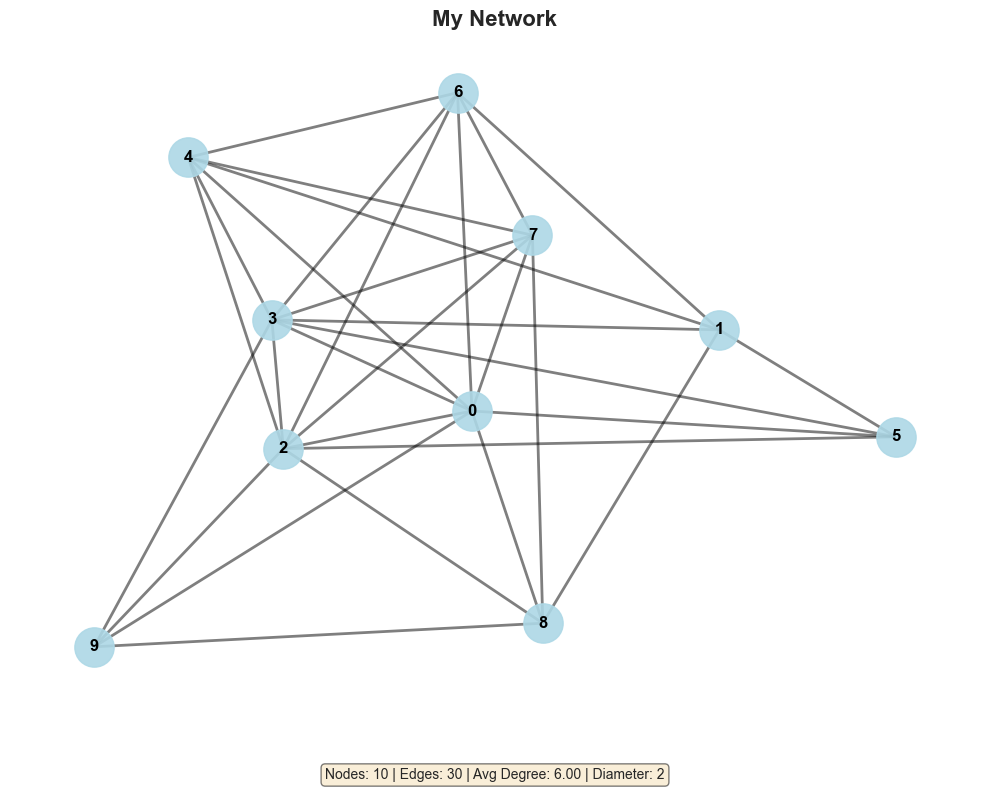

✓ Computed hop distances for 10 servers
✓ Generated random initial state (sparsity=0.3)
Loading dataset from 200netflix.csv...
✓ Loaded 310 request records from dataset
  Time slots: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,

In [65]:
config = uEDDEConfig()
server_capacities = [100000]*NUM_SERVERS
config.override(
    T=NUM_TIME_SLOTS,  
    num_datasets=NUM_DATASETS,
    num_servers=NUM_SERVERS,
    rho=0.3,  # More weight on worst-case
    K_failures=1,
    Gamma_budget=1.5,
    lambda_add=1.0,
    use_robust=True,
    use_ccg=True,
    solver_type="milp",
    solver_time_limit=100000000000,
    plot_per_slot=True,
    custom_dataset_path= "200netflix.csv",
    server_capacities = server_capacities
)
config.print_summary()
dataGen = DataGenerator(config)
dataGen.generate_all("data",activity=1)
dataGen.print_summary()



╔==============================================================================╗
║                    ONLINE uEDDE SOLVER                                       ║
╚==============================================================================╝
CONFIGURATION SUMMARY
Time Horizon: 200 slots
Datasets: 4, Servers: 10
Hop Budgets: {0: 2, 1: 3, 2: 2, 3: 3}
K-Failure Budget: 1
BS Uncertainty Budget (Γ): 1.5
Blend Parameter (ρ): 0.3
Solver: milp
Robust Optimization: Enabled


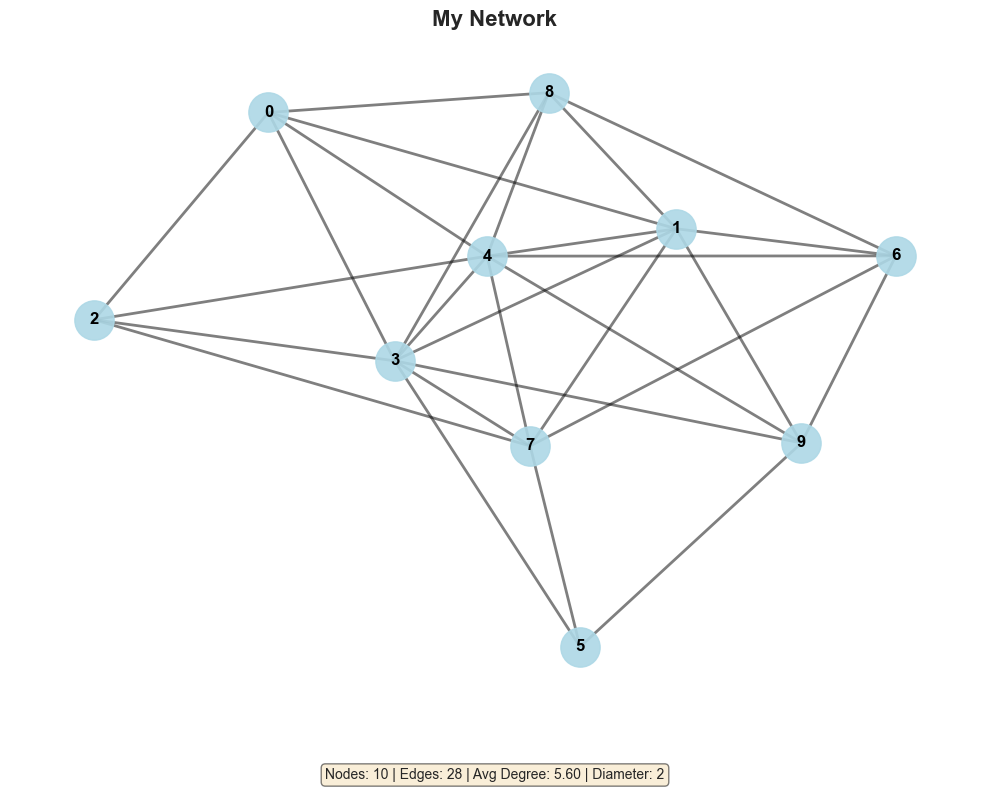


DATA SUMMARY
Initial placements: 10 replicas
Total requests: 317
Time slots with requests: {1: [0, 1], 10: [0, 2], 11: [0, 4, 2], 66: [0], 72: [0, 4, 9], 117: [0], 156: [0, 7], 4: [1, 2, 4], 12: [1, 7], 18: [1, 0], 24: [1], 89: [1], 95: [1], 164: [1, 8], 184: [1, 3], 2: [2], 6: [2, 1], 8: [2, 4], 39: [2, 7], 43: [2], 85: [2, 6, 9], 96: [2], 124: [2, 0, 7], 127: [2, 5], 134: [2, 9, 4, 5], 157: [2], 178: [2], 182: [2, 3, 5], 186: [2], 188: [2], 101: [3, 9], 150: [3], 16: [4, 5], 17: [4, 9], 26: [4, 0, 9, 2, 6, 8], 27: [4, 8], 29: [4], 34: [4, 1], 79: [4], 92: [4, 2], 103: [4], 132: [4], 147: [4, 8], 154: [4], 155: [4], 162: [4], 5: [5, 4], 41: [5], 141: [5], 143: [5], 200: [5, 6, 3, 2], 7: [6, 5], 13: [6, 8, 5], 21: [6, 4, 2], 119: [6], 172: [6, 1], 181: [6, 7], 35: [7, 2], 58: [7, 9], 116: [7], 149: [7, 2], 42: [8], 90: [8], 22: [9, 1], 114: [9, 2], 148: [9], 159: [9], 168: [9], 54: [0], 87: [0, 2, 8], 112: [0], 121: [0], 167: [0], 175: [0, 3], 25: [1, 6], 38: [1], 45: [1], 61: [1, 2],

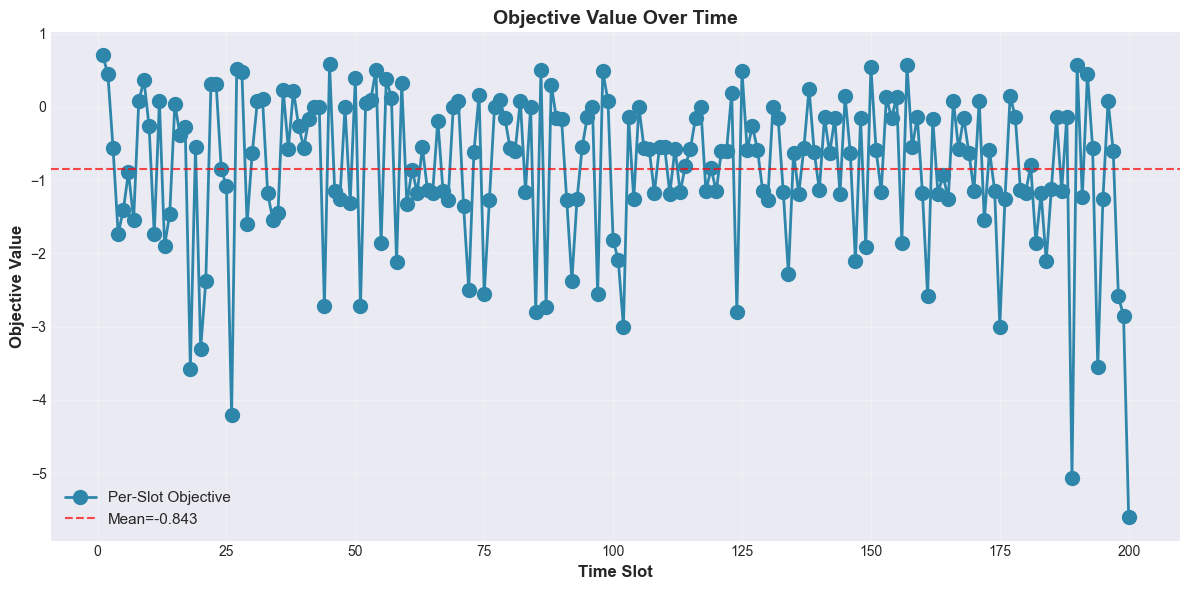

  Note: Provide k_sweep_results to visualize actual K sweep. Using current run only.


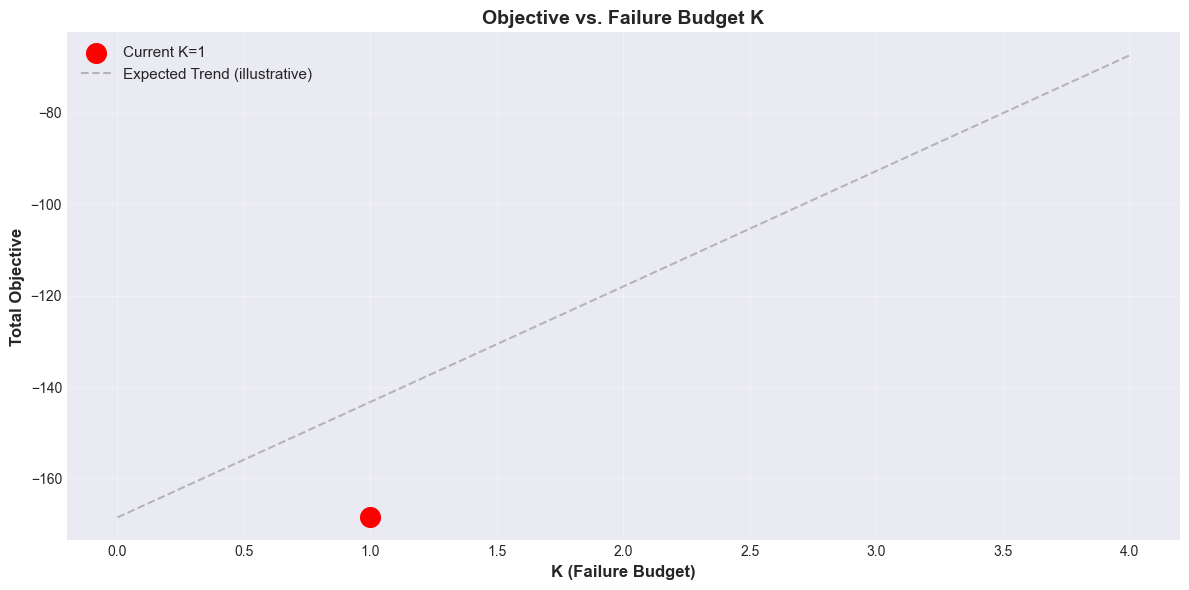

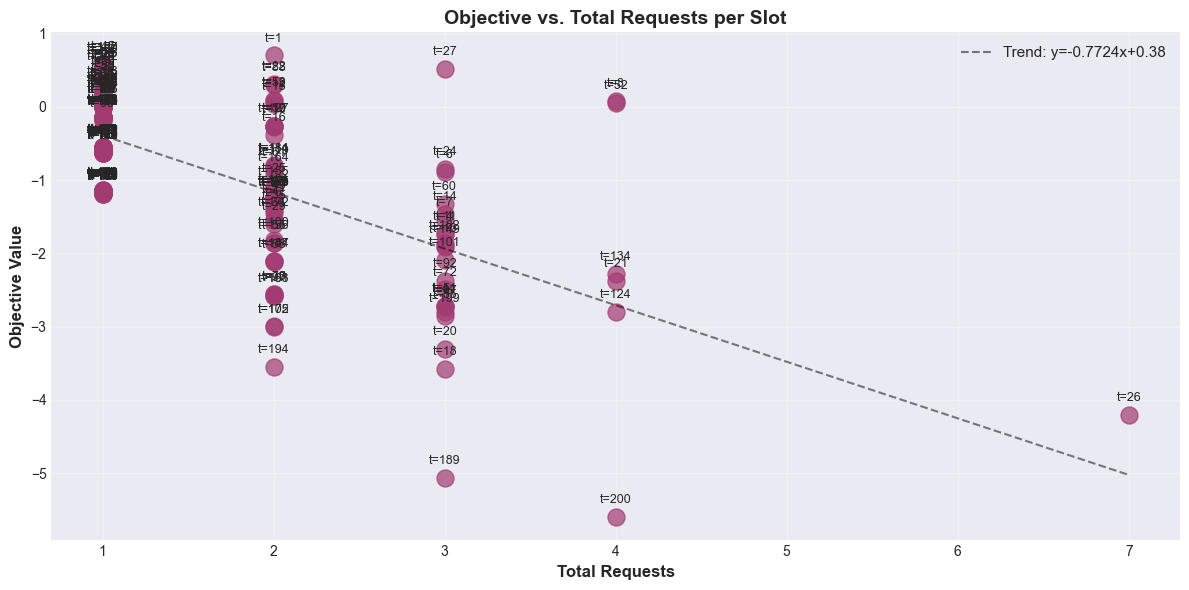

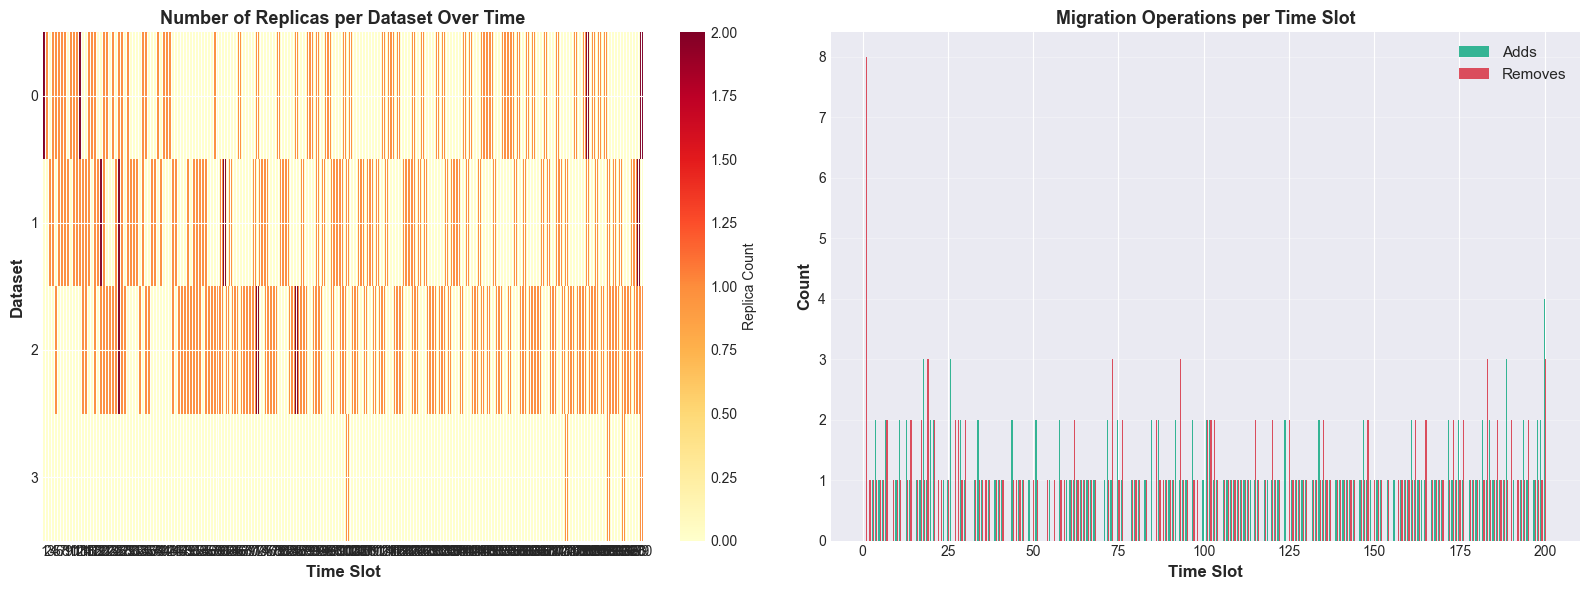

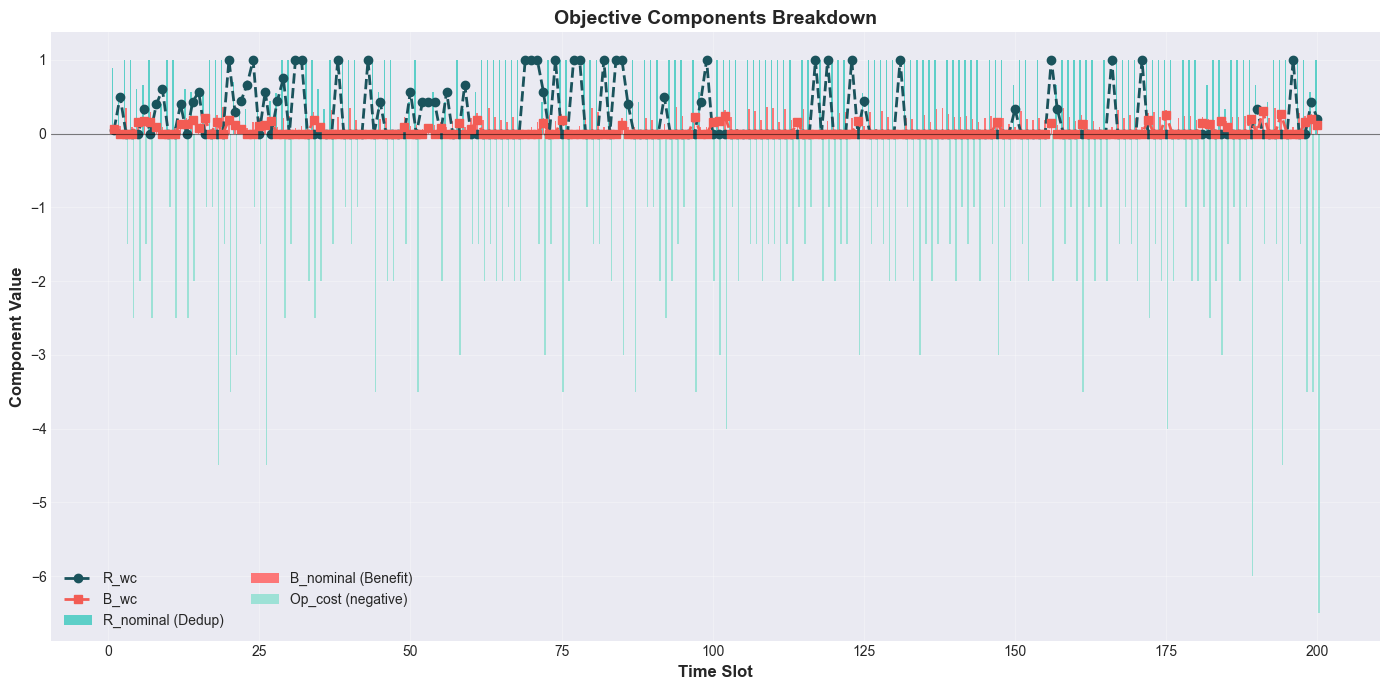

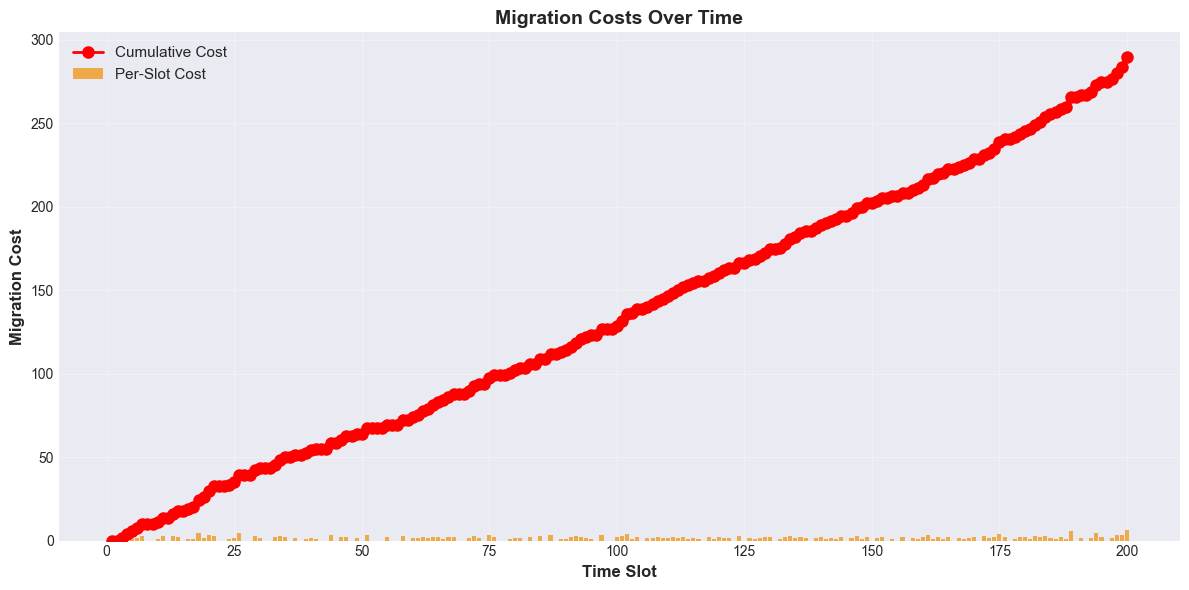

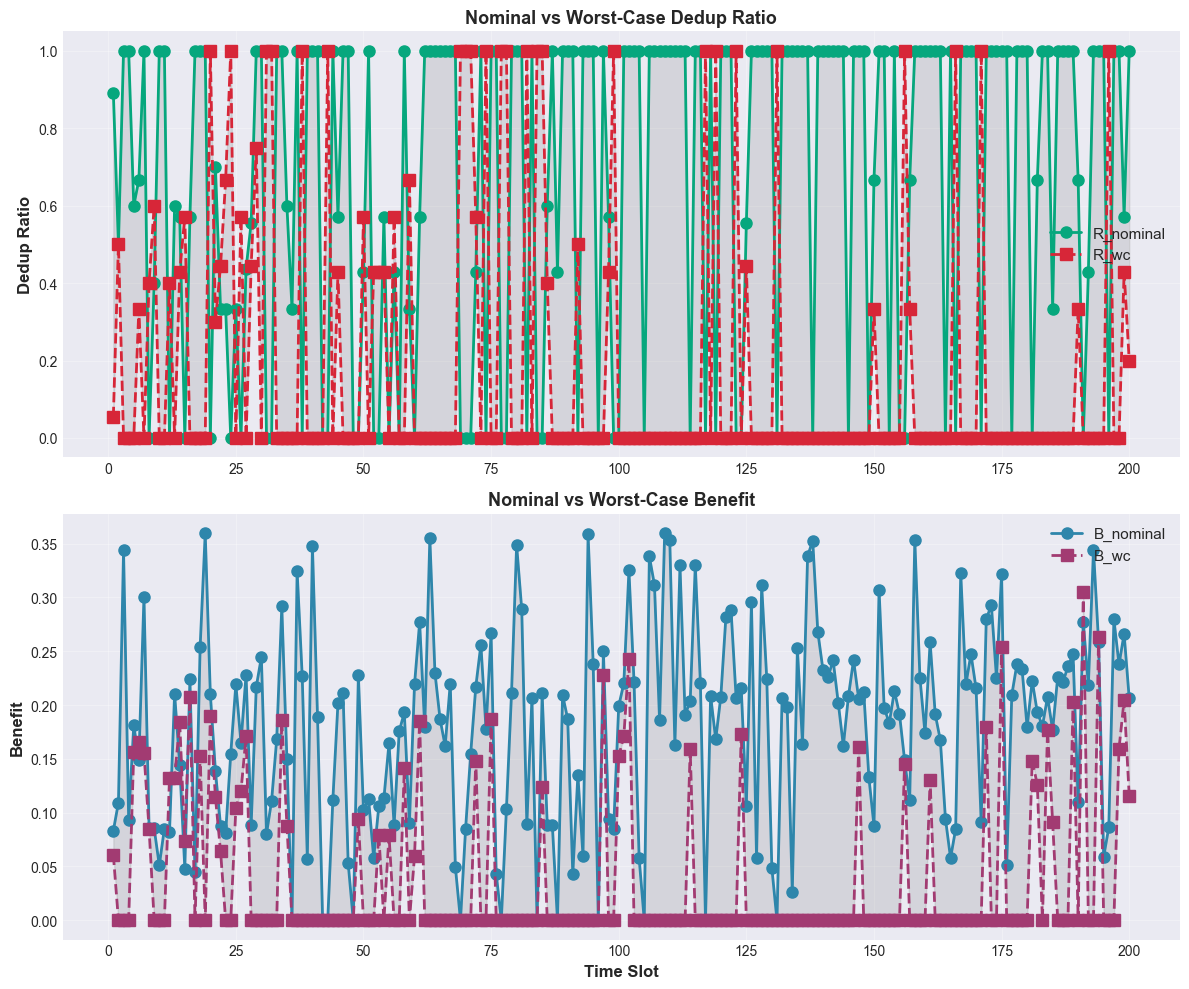

✓ All visualizations complete


In [315]:
solution_data = SolverFactory.solve_and_visualize(config, dataGen)

CONFIGURATION SUMMARY
Time Horizon: 200 slots
Datasets: 4, Servers: 10
Hop Budgets: {0: 2, 1: 3, 2: 2, 3: 3}
K-Failure Budget: 1
BS Uncertainty Budget (Γ): 1.5
Blend Parameter (ρ): 0.3
Solver: greedy
Robust Optimization: Enabled


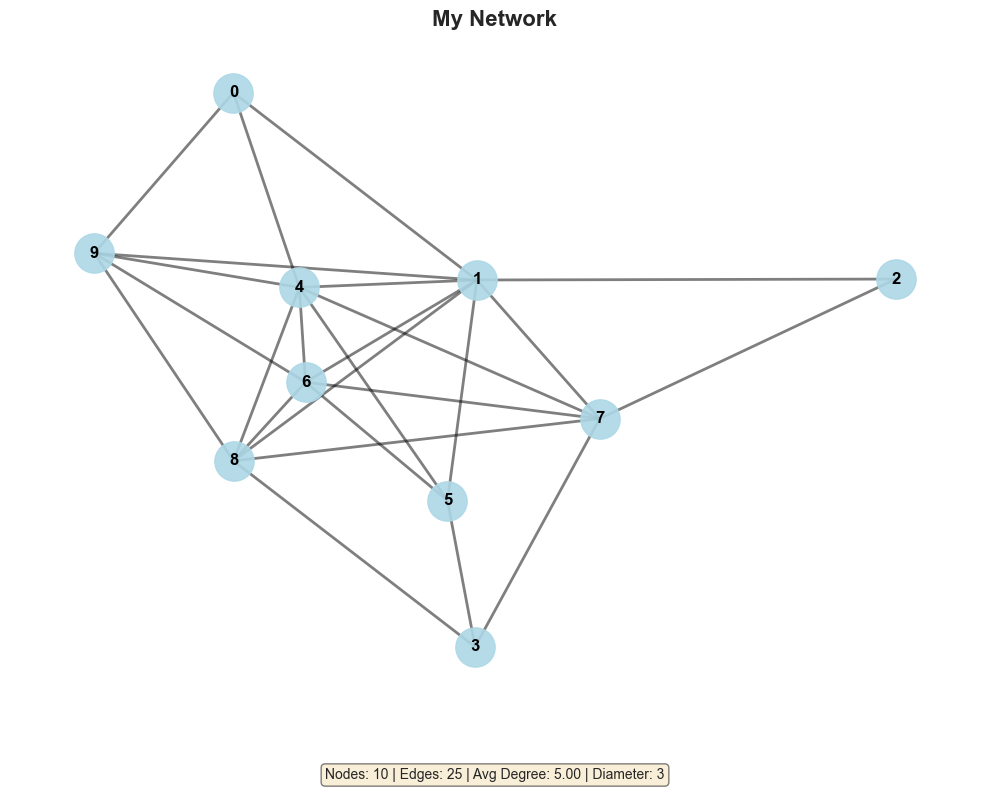

✓ Computed hop distances for 10 servers
✓ Generated random initial state (sparsity=0.3)
Loading dataset from 200netflix.csv...
✓ Loaded 310 request records from dataset
  Time slots: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,

In [66]:
config = uEDDEConfig()
server_capacities = [100000]*NUM_SERVERS
config.override(
    T=NUM_TIME_SLOTS,  
    num_datasets=NUM_DATASETS,
    num_servers=NUM_SERVERS,
    rho=0.3,  # More weight on worst-case
    K_failures=1,
    Gamma_budget=1.5,
    lambda_add=1.0,
    use_robust=True,
    use_ccg=False,
    solver_type="greedy",
    solver_time_limit=100000000000,
    plot_per_slot=True,
    custom_dataset_path= "200netflix.csv",
    server_capacities = server_capacities
)
config.print_summary()
dataGen = DataGenerator(config)
dataGen.generate_all("data",activity=1)
dataGen.print_summary()



╔==============================================================================╗
║                    ONLINE uEDDE SOLVER                                       ║
╚==============================================================================╝
CONFIGURATION SUMMARY
Time Horizon: 200 slots
Datasets: 4, Servers: 10
Hop Budgets: {0: 2, 1: 3, 2: 2, 3: 3}
K-Failure Budget: 1
BS Uncertainty Budget (Γ): 1.5
Blend Parameter (ρ): 0.3
Solver: greedy
Robust Optimization: Enabled


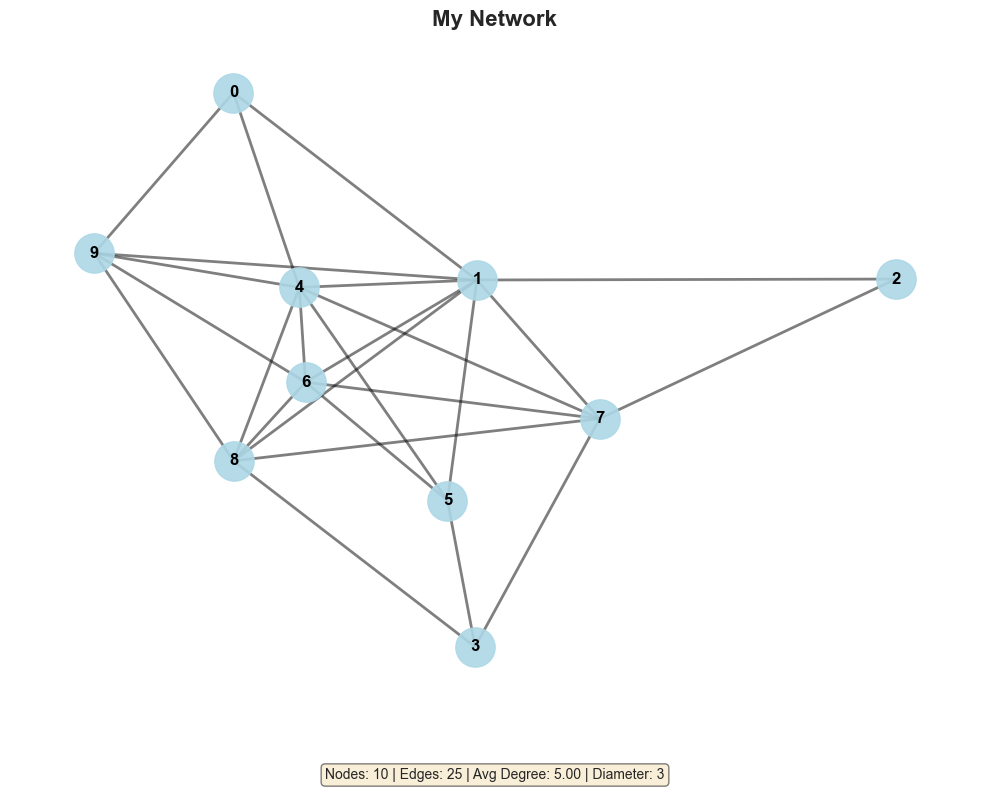


DATA SUMMARY
Initial placements: 10 replicas
Total requests: 317
Time slots with requests: {1: [0, 1], 10: [0, 2], 11: [0, 4, 2], 66: [0], 72: [0, 4, 9], 117: [0], 156: [0, 7], 4: [1, 2, 4], 12: [1, 7], 18: [1, 0], 24: [1], 89: [1], 95: [1], 164: [1, 8], 184: [1, 3], 2: [2], 6: [2, 1], 8: [2, 4], 39: [2, 7], 43: [2], 85: [2, 6, 9], 96: [2], 124: [2, 0, 7], 127: [2, 5], 134: [2, 9, 4, 5], 157: [2], 178: [2], 182: [2, 3, 5], 186: [2], 188: [2], 101: [3, 9], 150: [3], 16: [4, 5], 17: [4, 9], 26: [4, 0, 9, 2, 6, 8], 27: [4, 8], 29: [4], 34: [4, 1], 79: [4], 92: [4, 2], 103: [4], 132: [4], 147: [4, 8], 154: [4], 155: [4], 162: [4], 5: [5, 4], 41: [5], 141: [5], 143: [5], 200: [5, 6, 3, 2], 7: [6, 5], 13: [6, 8, 5], 21: [6, 4, 2], 119: [6], 172: [6, 1], 181: [6, 7], 35: [7, 2], 58: [7, 9], 116: [7], 149: [7, 2], 42: [8], 90: [8], 22: [9, 1], 114: [9, 2], 148: [9], 159: [9], 168: [9], 54: [0], 87: [0, 2, 8], 112: [0], 121: [0], 167: [0], 175: [0, 3], 25: [1, 6], 38: [1], 45: [1], 61: [1, 2],

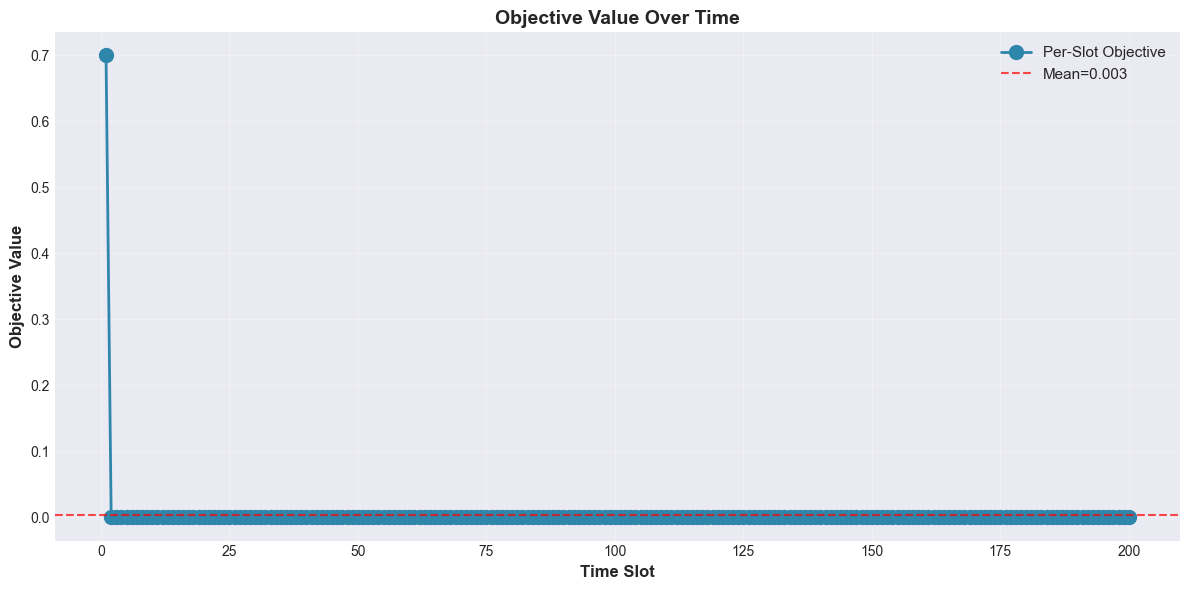

  Note: Provide k_sweep_results to visualize actual K sweep. Using current run only.


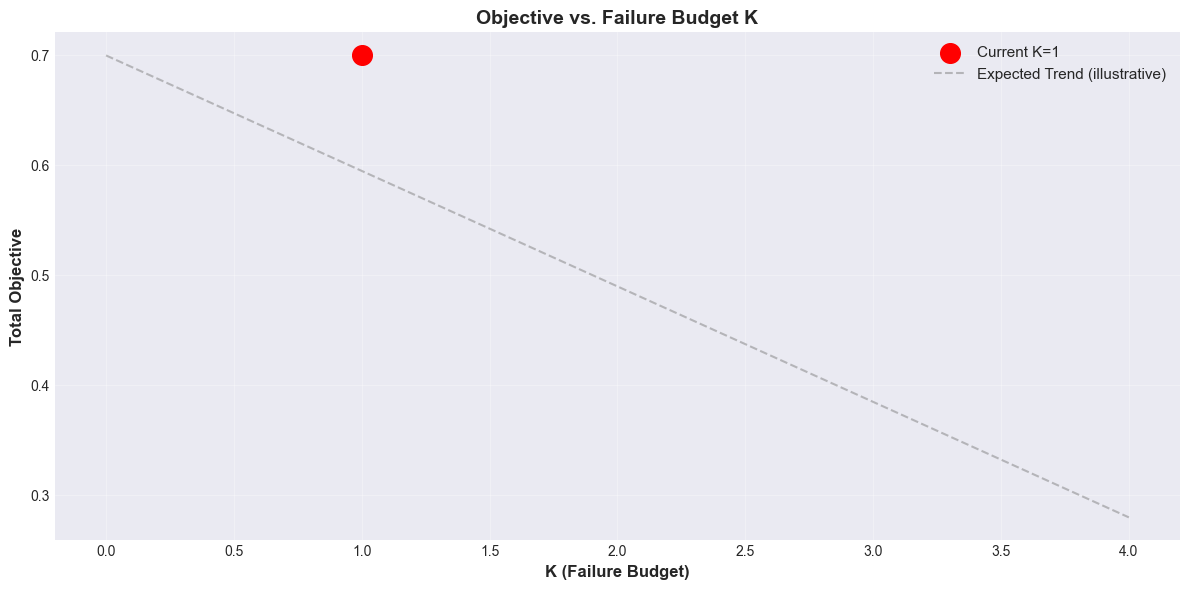

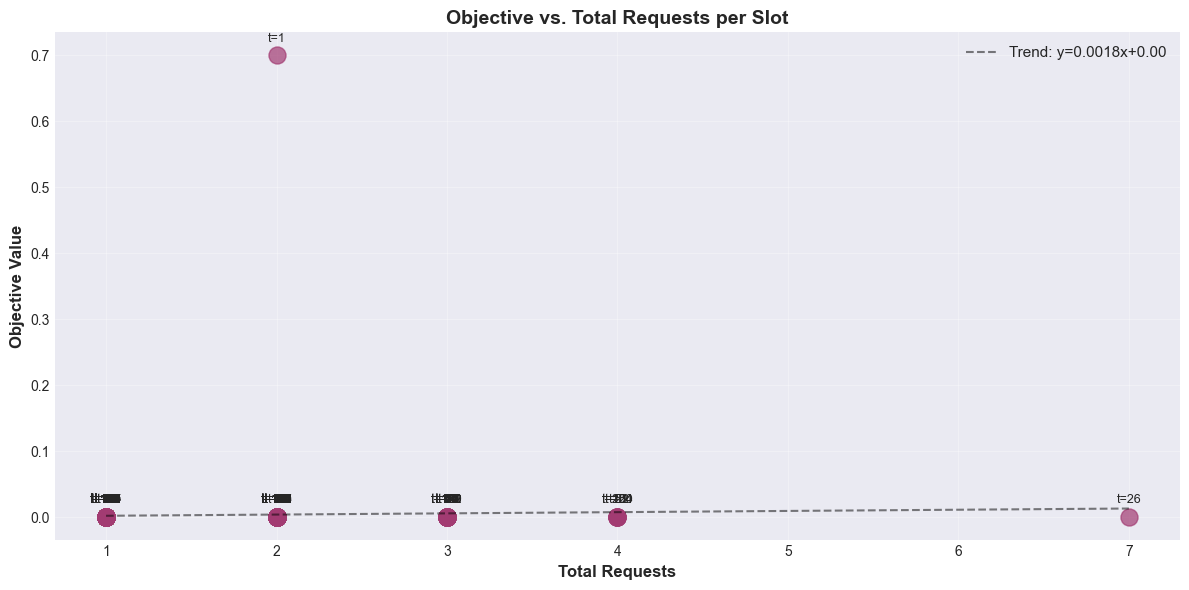

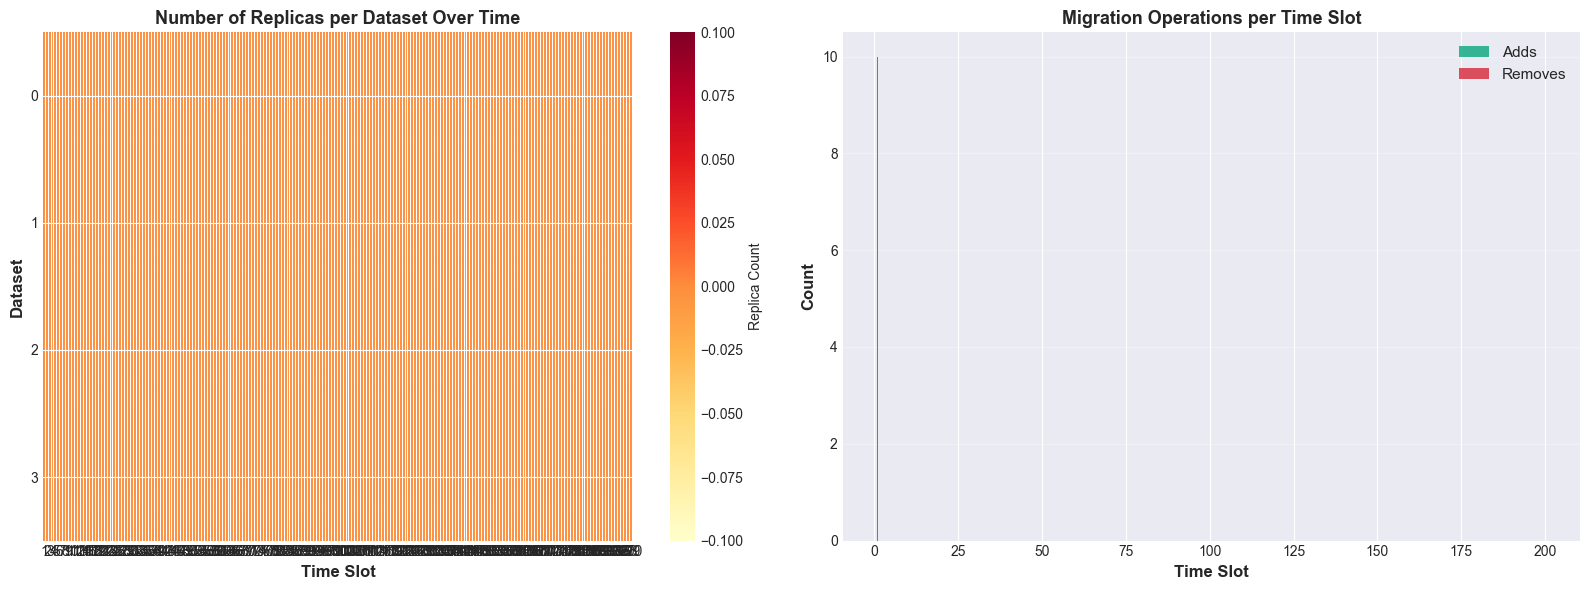

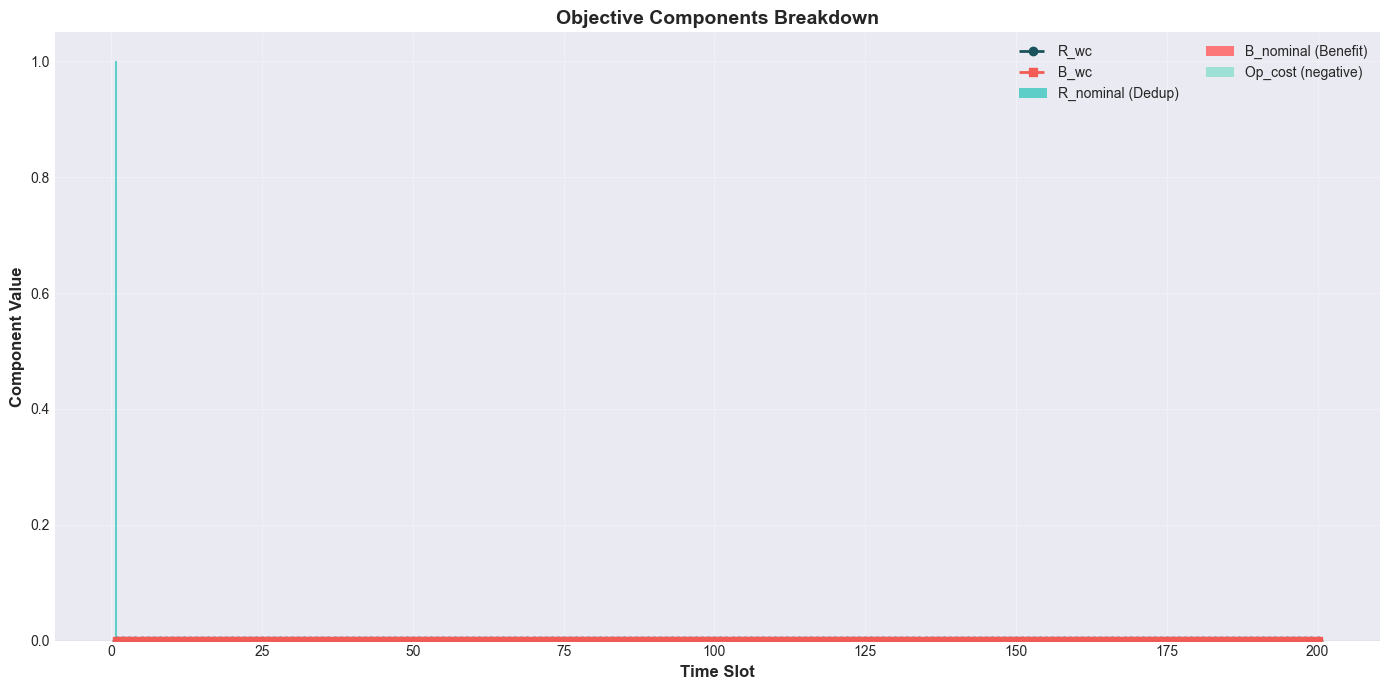

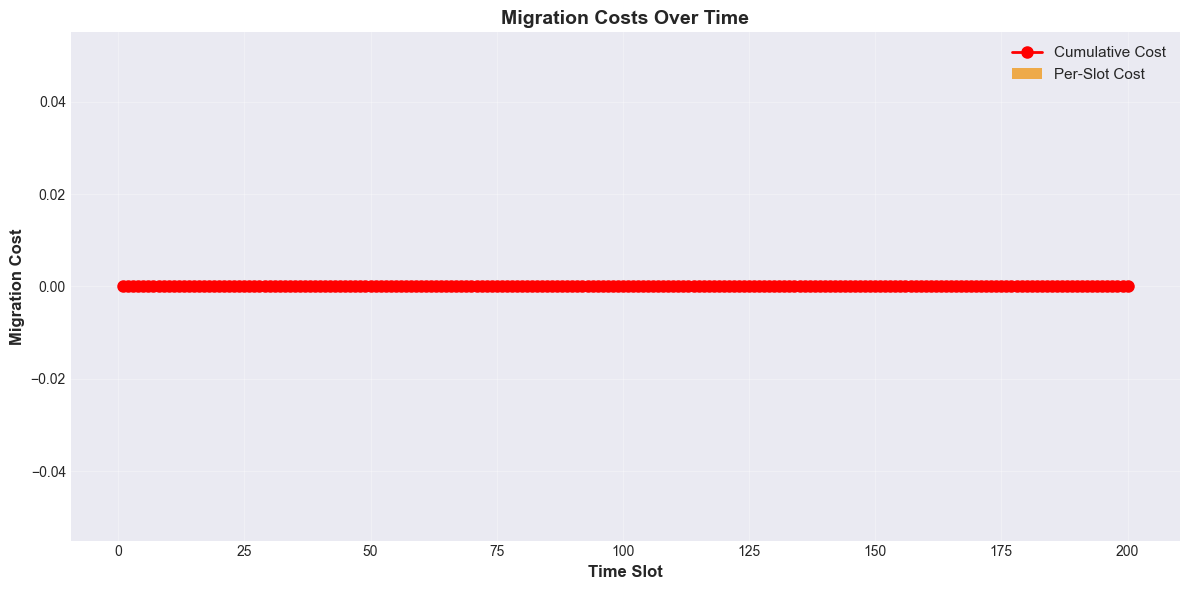

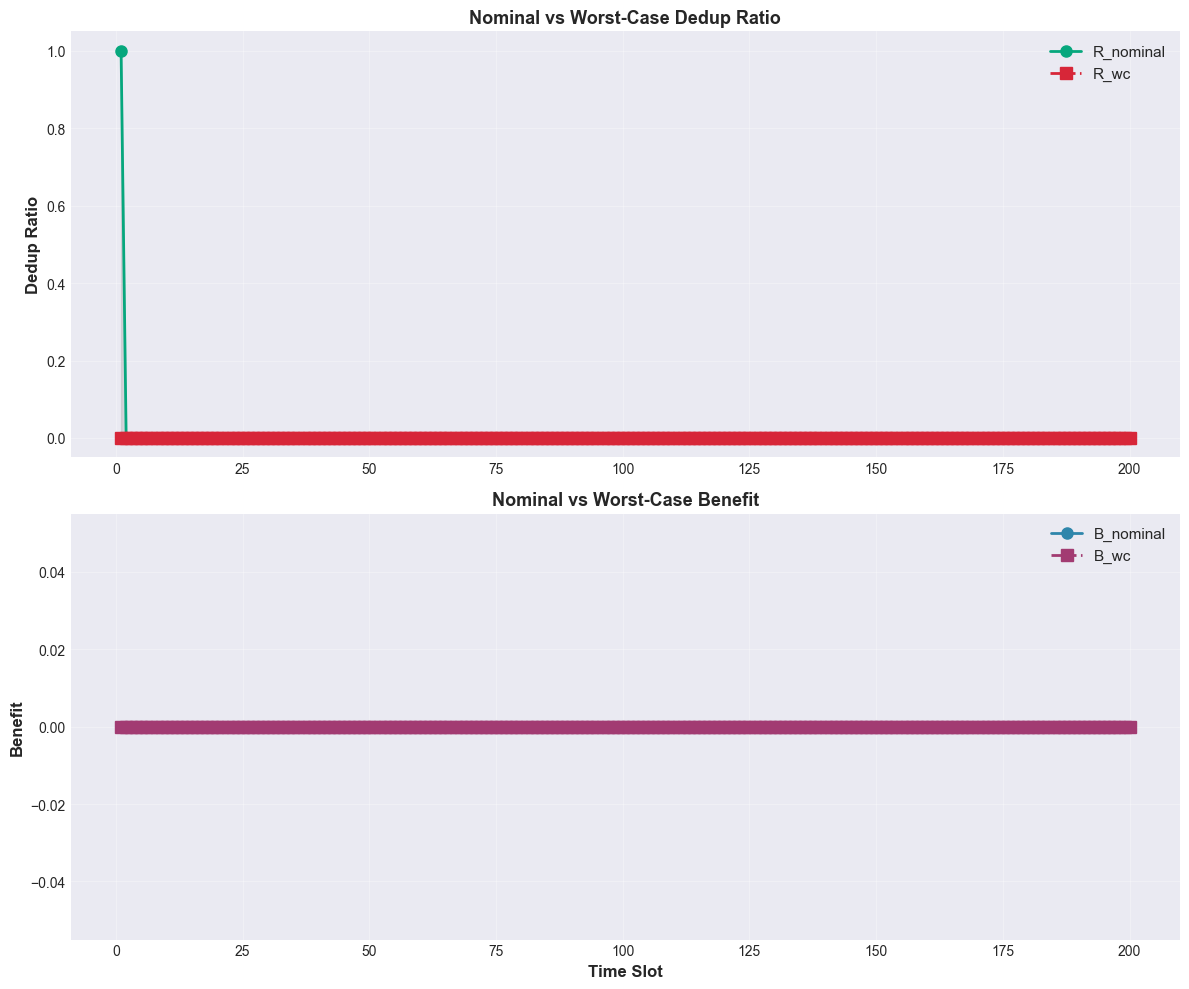

✓ All visualizations complete


In [67]:
solution_data = SolverFactory.solve_and_visualize(config, dataGen)

Netflix data processing (commented, just for remembring the process)

In [ ]:
# df = pd.read_csv("/Users/apple/Desktop/BTP/AdarshRaj-Sweeya/Smaller size Dataset Netflix/netflix_viral_10_set_2.csv")
# len(df)
# df.columns
# df = df.sort_values(["timestamp"])
# df.reindex(range(len(df)))
# values = df["timestamp"].unique()
# df["timeslot"] = 0
# for idx, val in enumerate(values):
#     df.loc[df["timestamp"] == val, "timeslot"] = idx
# df.drop("timestamp",inplace=True,axis=1)
# values = df["location"].unique()
# df["server"] = 0
# for idx, val in enumerate(values):
#     df.loc[df["location"] == val, "server"] = idx
# df.drop("location",inplace=True,axis=1)
# values = df["dataid"].unique()
# df["data"] = 0
# for idx, val in enumerate(values):
#     df.loc[df["dataid"] == val, "data"] = idx
# df.drop("dataid",inplace=True,axis=1)
# df.drop("userid",inplace=True,axis = 1)
# df.to_csv("netflix_processed.csv",index=False)

In [ ]:
# =============================================================================
# CUSTOM CONFIGURATION WITH MANUAL CONTROL
# =============================================================================

# Create custom configuration
config_custom = uEDDEConfig()

# Define custom network topology
custom_adjacency = {
    0: [1, 2, 3],    # Server 0 connects to 1, 2, 3
    1: [0, 3],       # Server 1 connects to 0, 3
    2: [0],          # Server 2 connects to 0
    3: [0, 1],       # Server 3 connects to 0, 
    # 4 :[2,0],
    # 5 :[1,4,3]
}

# Dataset-specific hop budgets
custom_hop_budgets = {
    0: 1,  # Dataset 0: strict latency (1 hop)
    1: 1,  # Dataset 1: strict latency
    2: 1,  # Dataset 2: strict latency
    3: 1,  # Dataset 3: strict latency
    4: 1,  # Dataset 4: strict latency
}

# Dataset sizes (GB)
custom_dataset_sizes = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
}
server_capacities = {
    0: 100.0,
    1: 150.0,
    2: 120.0,
    3: 80.0,
    4: 200.0,
    # 5: 250.0,
}

config_custom.override(
    T=5,  
    num_datasets=4,
    num_servers=5,
    adjacency=custom_adjacency,
    hop_budgets=custom_hop_budgets,
    dataset_sizes=custom_dataset_sizes,
    rho=0.3,  # More weight on worst-case
    K_failures=1,
    Gamma_budget=1.5,
    lambda_add=1.0,
    use_robust=True,
    use_ccg=True,
    solver_type="milp",
    solver_time_limit=100000000000,
    plot_per_slot=True,
    server_capacities=server_capacities
)

print("✓ Custom configuration created")
config_custom.print_summary()

# =============================================================================
# MANUAL INPUT DATA (Initial State and Request Counts)
# =============================================================================

# Create data generator

data_custom = DataGenerator(config_custom)

# Manual initial placement A_{ij,0}
manual_initial = {
    (1, 0): 1, (2, 0): 1,  # Server 0: datasets 1, 2
    (0, 1): 1, (2, 1): 1, (3, 1): 1,  # Server 1: datasets 0, 2, 3
    (0, 2): 1, (1, 2): 1, (2, 2): 1, (3, 2): 1, (4, 2): 1,  # Server 2: all datasets
    (0, 3): 1, (1, 3): 1, (3, 3): 1, (4, 3): 1,  # Server 3: datasets 0, 1, 3, 4
    # (0, 4): 1, (4, 4): 1,  # Server 4: all datasets
    # (1, 5): 1, (3, 5): 1,  # Server 5: datasets 1, 3
}

# Fill remaining with zeros
for i in range(config_custom.num_datasets):
    for j in range(config_custom.num_servers):
        if (i, j) not in manual_initial:
            manual_initial[(i, j)] = 0

# Manual request counts N^i_{p,t} (dataset, AP, time)
manual_counts = {
    # AP 0 (Server 0)
    (0, 0, 1): 9,
    (1, 0, 1): 10,
    (2, 0, 1): 2,
    (3, 0, 1): 4,
    (4, 0, 1): 8,
    
    # AP 1 (Server 1)
    (0, 1, 1): 12,
    (1, 1, 1): 6,
    (2, 1, 1): 2,
    (3, 1, 1): 8,
    (4, 1, 1): 29,
    
    # AP 2 (Server 2)
    (0, 2, 1): 0,
    (1, 2, 1): 2,
    (2, 2, 1): 22,
    (3, 2, 1): 13,
    (4, 2, 1): 7,
    
    # AP 3 (Server 3)
    (0, 3, 1): 1,
    (1, 3, 1): 0,
    (2, 3, 1): 3,
    (3, 3, 1): 7,
    (4, 3, 1): 0,
}

# All datasets active at time 1
manual_active = {
    (0, 1): 1,
    (1, 1): 1,
    (2, 1): 1,
    (3, 1): 1,
    (4, 1): 1,
}

# Set manual data
data_custom.generate_initial_state(manual_initial)
data_custom.generate_counts()
data_custom.generate_active_datasets()
data_custom.generate_weights()

print("✓ Manual data loaded")
data_custom.print_summary()

In [ ]:
solution_custom = SolverFactory.solve_and_visualize(config_custom, data_custom)

---

# Example 3: Greedy Solver for Fast Heuristic Solution

In [ ]:
# Use Greedy-ADR solver for faster solution
config_greedy = uEDDEConfig()

# Define custom network topology
custom_adjacency = {
    0: [1, 2, 3],    # Server 0 connects to 1, 2, 3
    1: [0, 3],       # Server 1 connects to 0, 3
    2: [0],          # Server 2 connects to 0
    3: [0, 1],       # Server 3 connects to 0, 1
}

# Dataset-specific hop budgets
custom_hop_budgets = {
    0: 1,  # Dataset 0: strict latency (1 hop)
    1: 1,  # Dataset 1: strict latency
    2: 1,  # Dataset 2: strict latency
    3: 1,  # Dataset 3: strict latency
    4: 1,  # Dataset 4: strict latency
}

# Dataset sizes (GB)
custom_dataset_sizes = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
}
server_capacities = {
    0: 100.0,
    1: 150.0,
    2: 120.0,
    3: 80.0,
    4: 200.0,
}
config_greedy.override(
    T=100,  # Single time slot
    num_datasets=5,
    num_servers=4,
    adjacency=custom_adjacency,
    hop_budgets=custom_hop_budgets,
    dataset_sizes=custom_dataset_sizes,
    enforce_recourse_from_prev = True,
    rho=0.8,  # More weight on worst-case
    K_failures=1,
    Gamma_budget=1.5,
    lambda_add=1.0,
    # lambda_remove = 0.3,
    use_robust=True,
    use_ccg=False,
    solver_type="greedy_adr",
    solver_time_limit=100000000000,
    plot_per_slot=True,
    server_capacities=server_capacities
)
manual_initial = {
    (1, 0): 1, (2, 0): 1,  # Server 0: datasets 1, 2
    (0, 1): 1, (2, 1): 1, (3, 1): 1,  # Server 1: datasets 0, 2, 3
    (0, 2): 1, (1, 2): 1, (2, 2): 1, (3, 2): 1, (4, 2): 1,  # Server 2: all datasets
    (0, 3): 1, (1, 3): 1, (3, 3): 1, (4, 3): 1,  # Server 3: datasets 0, 1, 3, 4
}

for i in range(config_custom.num_datasets):
    for j in range(config_custom.num_servers):
        if (i, j) not in manual_initial:
            manual_initial[(i, j)] = 0

data_greedy = DataGenerator(config_greedy)
data_greedy.generate_initial_state(manual_initial)
data_greedy.generate_counts()
data_greedy.generate_active_datasets()
data_greedy.generate_weights()
data_greedy.print_summary()

In [ ]:
solution_greedy = SolverFactory.solve_and_visualize(config_greedy, data_greedy)

---

# Example 4: Parameter Sensitivity Analysis

Compare different configurations (rho, K, Gamma)

✓ Computed hop distances for 10 servers
✓ Generated random initial state (sparsity=0.3)
Loading dataset from 200netflix.csv...
✓ Loaded 310 request records from dataset
  Time slots: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,

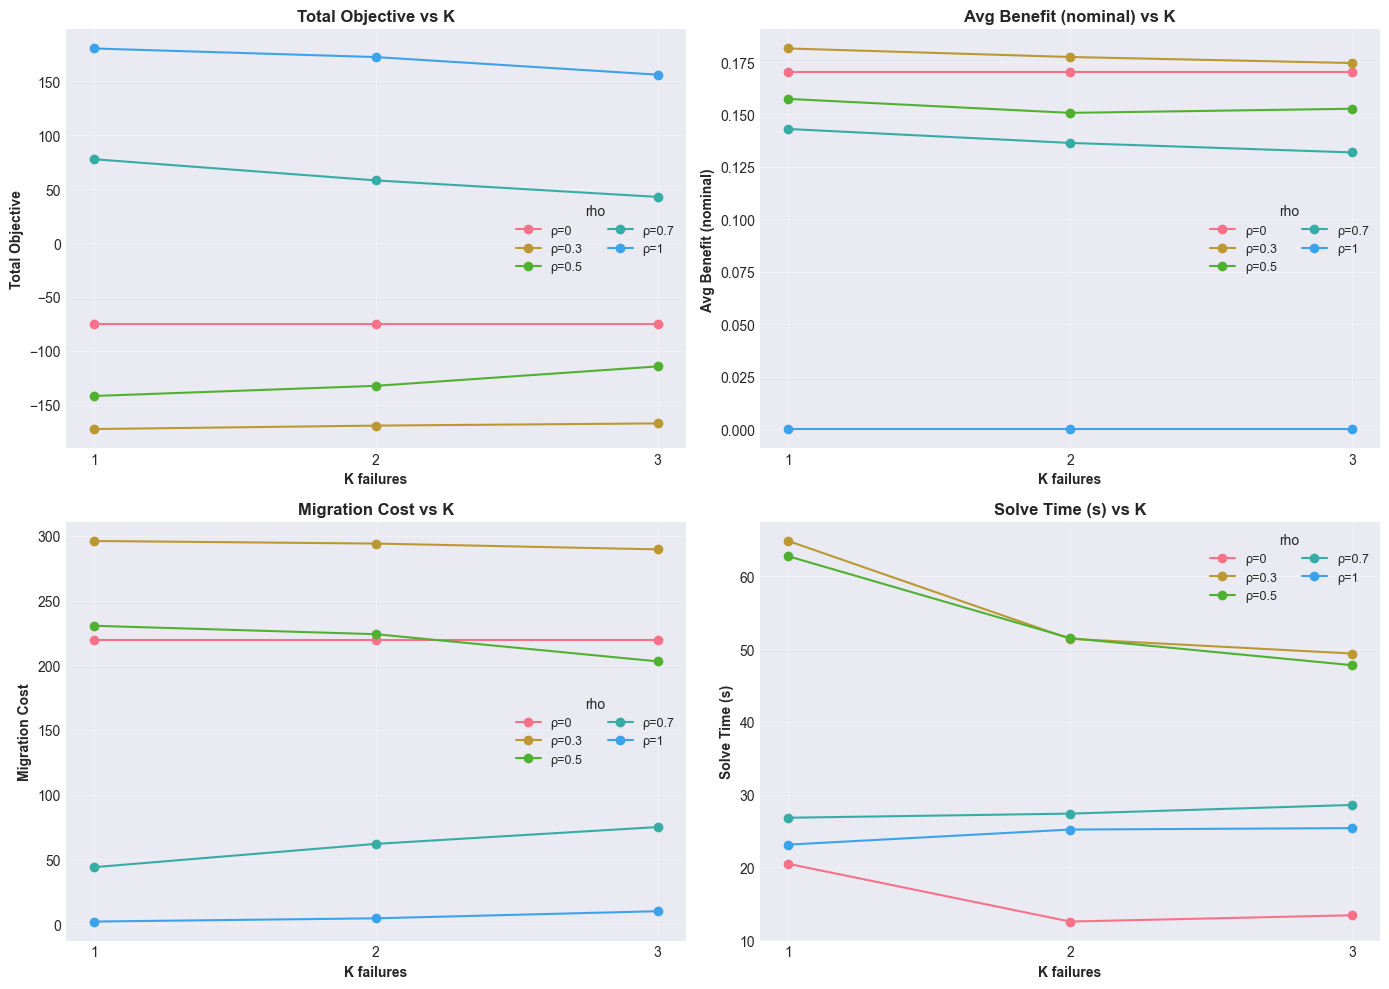

In [337]:
# =============================================================================
# PARAMETER SENSITIVITY ANALYSIS: (rho, K) with line plots
# =============================================================================

def run_sensitivity_analysis(
    rho_list=(0.0, 0.3, 0.5, 0.7, 1.0),
    K_list=(0, 1, 2),                 # keep <= num_servers
    T_SLOTS=20,
    seed=42,
    use_manual_initial=False,
    show_plots=True
):
    results = []

    config = uEDDEConfig()
    server_capacities = [100000]*NUM_SERVERS
    config.override(
        T=NUM_TIME_SLOTS,  
        num_datasets=NUM_DATASETS,
        num_servers=NUM_SERVERS,
        rho=0.3,  # More weight on worst-case
        K_failures=1,
        Gamma_budget=1.5,
        lambda_add=1.0,
        use_robust=True,
        use_ccg=True,
        solver_type="milp",
        solver_time_limit=100000000000,
        plot_per_slot=True,
        custom_dataset_path= "200netflix.csv",
        server_capacities = server_capacities
    )
    # config.print_summary()
    # dataGen = DataGenerator(config)
    # dataGen.generate_all("data",activity=1)
    # dataGen.print_summary()

    base_data = DataGenerator(config, seed=seed)
    if use_manual_initial:
        base_data.generate_initial_state(manual_initial)
        base_data.generate_counts()   
        base_data.generate_active_datasets()    # synthetic alpha
        base_data.generate_weights()        # synthetic counts for all t
    else:
        base_data.generate_all("data",activity=1)

    # Freeze everything so every (rho, K) run uses identical data
    frozen = {
        "initial_state": dict(base_data.initial_state),
        "counts": dict(base_data.counts),
        "weights_nominal": dict(base_data.weights_nominal),
        "weights_error": dict(base_data.weights_error),
        "active_datasets": dict(base_data.active_datasets),
        "attachment_points": {t: list(aps) for t, aps in base_data.attachment_points.items()},
        "hop_distances": dict(config.hop_distances),
    }

    print("\n" + "="*80)
    print("SENSITIVITY ANALYSIS: Joint grid over (rho, K)")
    print("="*80)

    for K in K_list:
        if K > NUM_SERVERS:
            print(f"Skipping K={K} (exceeds num_servers).")
            continue

        for rho in rho_list:
            print(f"\n--- Testing (rho={rho}, K={K}) ---")

            # Fresh config per grid point
            cfg = uEDDEConfig()
            cfg.override(
                T=NUM_TIME_SLOTS,  
                num_datasets=NUM_DATASETS,
                num_servers=NUM_SERVERS,
                rho= float(rho),  
                K_failures=int(K),
                Gamma_budget=1.5,
                lambda_add=1.0,
                use_robust=True,
                use_ccg=True,
                solver_type="milp",
                solver_time_limit=100000000000,
                plot_per_slot=False,
                custom_dataset_path= "200netflix.csv",
                server_capacities = server_capacities
            )

            # Reuse frozen hop distances
            cfg.hop_distances = dict(frozen["hop_distances"])

            # Fresh data object loaded from frozen dicts
            data = DataGenerator(cfg, seed=seed)
            data.initial_state     = dict(frozen["initial_state"])
            data.counts            = dict(frozen["counts"])
            data.weights_nominal   = dict(frozen["weights_nominal"])
            data.weights_error     = dict(frozen["weights_error"])
            data.active_datasets   = dict(frozen["active_datasets"])
            data.attachment_points = {t: list(v) for t, v in frozen["attachment_points"].items()}

            # Solve
            solver = SolverFactory.create_solver(cfg, data)
            sol = solver.solve_all()

            # Collect metrics
            avg_R_nom  = np.mean([s.R_nominal for s in sol.slot_solutions]) if sol.slot_solutions else 0.0
            avg_B_nom  = np.mean([s.B_nominal for s in sol.slot_solutions]) if sol.slot_solutions else 0.0
            tot_cost   = float(sum(s.Op_cost for s in sol.slot_solutions))
            feas_slots = sum(1 for s in sol.slot_solutions if s.status in ("Optimal", "Feasible"))

            results.append({
                "rho": float(rho),
                "K": int(K),
                "Gamma": cfg.Gamma_budget,
                "T": T_SLOTS,
                "total_obj": float(sol.total_objective),
                "avg_R_nom": float(avg_R_nom),
                "avg_B_nom": float(avg_B_nom),
                "total_cost": float(tot_cost),
                "solve_time": float(sol.total_solve_time),
                "feasible_slots": int(feas_slots),
            })

    # ---------------------------------
    # Results table
    # ---------------------------------
    df = pd.DataFrame(results).sort_values(["K", "rho"]).reset_index(drop=True)
    print("\n" + "="*80)
    print("SENSITIVITY ANALYSIS RESULTS (grid over (rho, K))")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)

    # ---------------------------------
    # Line plots: K on x; one line per rho
    # ---------------------------------
    if show_plots and len(df):
        metrics = [
            ("total_obj",  "Total Objective"),
            ("avg_B_nom",  "Avg Benefit (nominal)"),
            ("total_cost", "Migration Cost"),
            ("solve_time", "Solve Time (s)")
        ]

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.ravel()

        K_vals   = sorted(df["K"].unique())
        rho_vals = sorted(df["rho"].unique())

        for ax, (metric, ylabel) in zip(axes, metrics):
            for rho in rho_vals:
                sub = df[df["rho"] == rho]
                # Ensure values align to all K on x-axis (NaN if missing)
                y = [sub.loc[sub["K"] == K, metric].values[0] if (sub["K"] == K).any() else np.nan
                     for K in K_vals]
                ax.plot(K_vals, y, marker="o", label=f"ρ={rho:g}")
            ax.set_title(f"{ylabel} vs K", fontweight="bold")
            ax.set_xlabel("K failures", fontweight="bold")
            ax.set_ylabel(ylabel, fontweight="bold")
            ax.set_xticks(K_vals)
            ax.grid(True, alpha=0.3)
            ax.legend(title="rho", fontsize=9, ncol=2)

        plt.tight_layout()
        plt.show()

    return df

# ----- Example call -----
sensitivity_grid = run_sensitivity_analysis(
    rho_list=(0.0, 0.3, 0.5, 0.7, 1.0),
    K_list=(1,2,3),
    T_SLOTS=20,
    seed=42,
    use_manual_initial=False,
    show_plots=True
)
